# **Financial Stocks Data**

For this dataset, we will perform an EDA on some stocks of banks from the financial crisis to early 2016. Later, we will also try to fit a regression model to try and capture the trend that the data follows.  
We will get the data for some of the biggest American Banks: 
* Bank of America
* CitiGroup
* Goldman Sachs
* JPMorgan Chase
* Morgan Stanley 
* Wells Fargo

In [ ]:
# Import some libraries
from pandas_datareader import data, wb # To get our data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime # For date format
import statsmodels.api as sm # For decomposing plots
sns.set_style("whitegrid") # Set a default seaborn style


In [ ]:
# We will have the same start and end for all the banks
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2020, 1, 1)

# Bank of America
BAC = data.DataReader("BAC", "yahoo", start, end)[["High", "Low", 
                                                   "Open", "Close", "Volume"]]
# For this we got the Date as an Index, High, Low, Open, Close, Volume and 
# Adjusted Close
# Grab everything other than the adjusted close
# CitiGroup
C = data.DataReader("C", "yahoo", start, end)[["High", "Low", 
                                                   "Open", "Close", "Volume"]]
# Goldman Sachs
GS = data.DataReader("GS", "yahoo", start, end)[["High", "Low", 
                                                   "Open", "Close", "Volume"]]
# JPMorgan Chase
JPM = data.DataReader("JPM", "yahoo", start, end)[["High", "Low", 
                                                   "Open", "Close", "Volume"]]
# Morgan Stanley
MS = data.DataReader("MS", "yahoo", start, end)[["High", "Low", 
                                                   "Open", "Close", "Volume"]]
# Wells Fargo
WFC = data.DataReader("WFC", "yahoo", start, end)[["High", "Low", 
                                                   "Open", "Close", "Volume"]]

In [ ]:
# Create a list of tickers
tickers = "BAC C GS JPM MS WFC".split()
# Concatenate over columns (set axis = 1)
bank_stocks = pd.concat([BAC, C, GS, JPM, MS, WFC], axis = 1, keys = tickers)
# Add column names
bank_stocks.columns.names = ["Bank Ticker", "Stock Info"]
# What does our data look like right now?
bank_stocks.head()

Bank Ticker        BAC                        ...        WFC                       
Stock Info        High        Low       Open  ...       Open      Close      Volume
Date                                          ...                                  
2006-01-03   47.180000  46.150002  46.919998  ...  31.600000  31.900000  11016400.0
2006-01-04   47.240002  46.450001  47.000000  ...  31.799999  31.530001  10870000.0
2006-01-05   46.830002  46.320000  46.580002  ...  31.500000  31.495001  10158000.0
2006-01-06   46.910000  46.349998  46.799999  ...  31.580000  31.680000   8403800.0
2006-01-09   46.970001  46.360001  46.720001  ...  31.674999  31.674999   5619600.0

[5 rows x 30 columns]

# **EDA**

We will calculate the percent return for each stock. The return is defined as  
$r_t = \frac{p_t - p_{t-1}}{p_{t-1}} = \frac{p_t}{p_{t-1}} - 1$

In [ ]:
returns = pd.DataFrame()
for ticker in tickers:
  returns[ticker + " Return"] = bank_stocks[ticker]["Close"].pct_change()

# What does our returns df look like?
returns.head(10)
# Makes sense that the first one is NaN because we can't compare it to anything

BAC Return  C Return  GS Return  JPM Return  MS Return  WFC Return
Date                                                                          
2006-01-03         NaN       NaN        NaN         NaN        NaN         NaN
2006-01-04   -0.010620 -0.018462  -0.013812   -0.014183   0.000686   -0.011599
2006-01-05    0.001288  0.004961  -0.000393    0.003029   0.002742   -0.001110
2006-01-06   -0.001501  0.000000   0.014169    0.007046   0.001025    0.005874
2006-01-09    0.000644 -0.004731   0.012030    0.016242   0.010586   -0.000158
2006-01-10   -0.008369  0.003100   0.012578    0.001475   0.000507   -0.000789
2006-01-11   -0.002380  0.009065  -0.000454   -0.000737   0.005910    0.005213
2006-01-12   -0.006508  0.001021   0.002122   -0.018428  -0.001679   -0.011630
2006-01-13    0.000000 -0.002243   0.007637   -0.000751  -0.001513    0.005724
2006-01-17   -0.010699 -0.010016  -0.005028   -0.005260  -0.009599   -0.010277

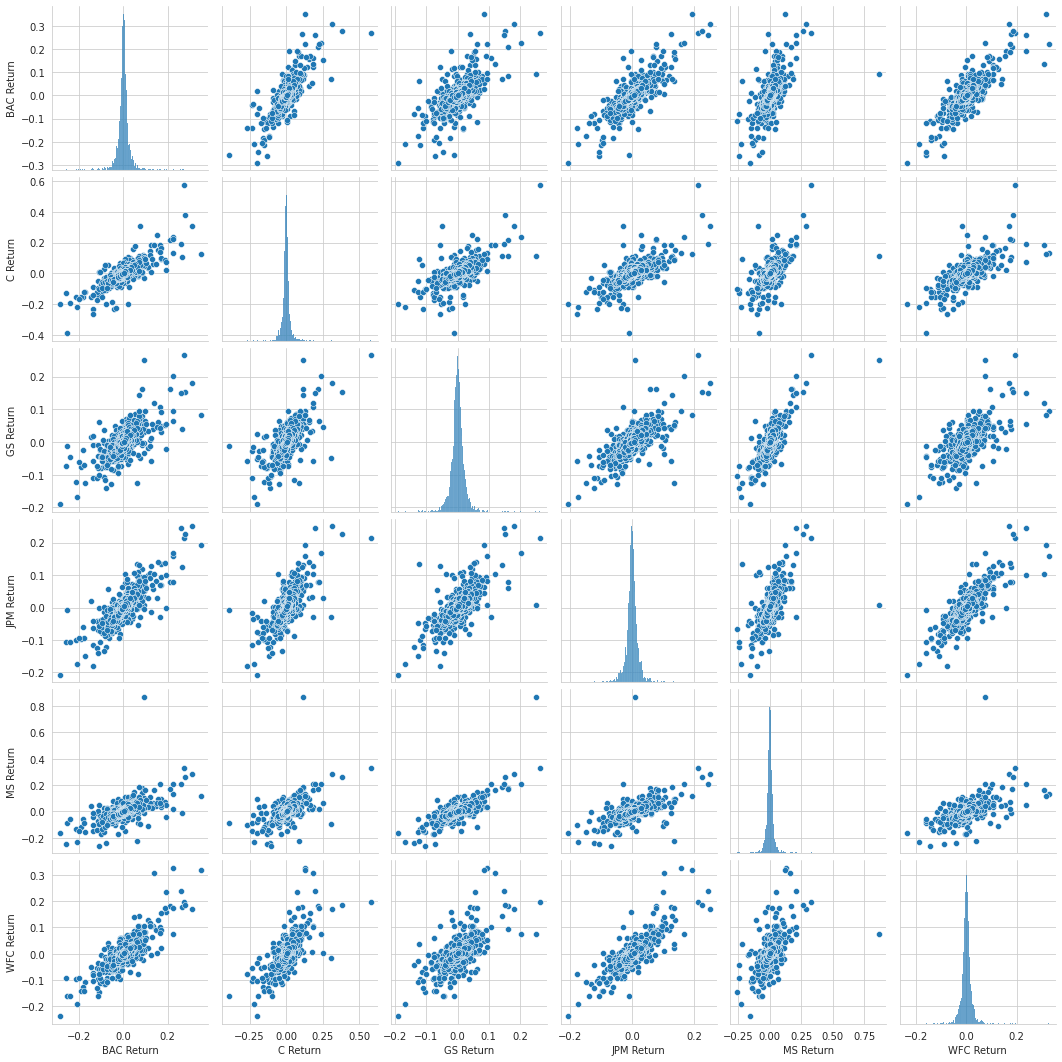

In [ ]:
# What trends do we see in the returns df?
sns.pairplot(returns[1:])
plt.show()
# Nothing seems too out of the ordinary, all of them are heavily centered 
# around 0

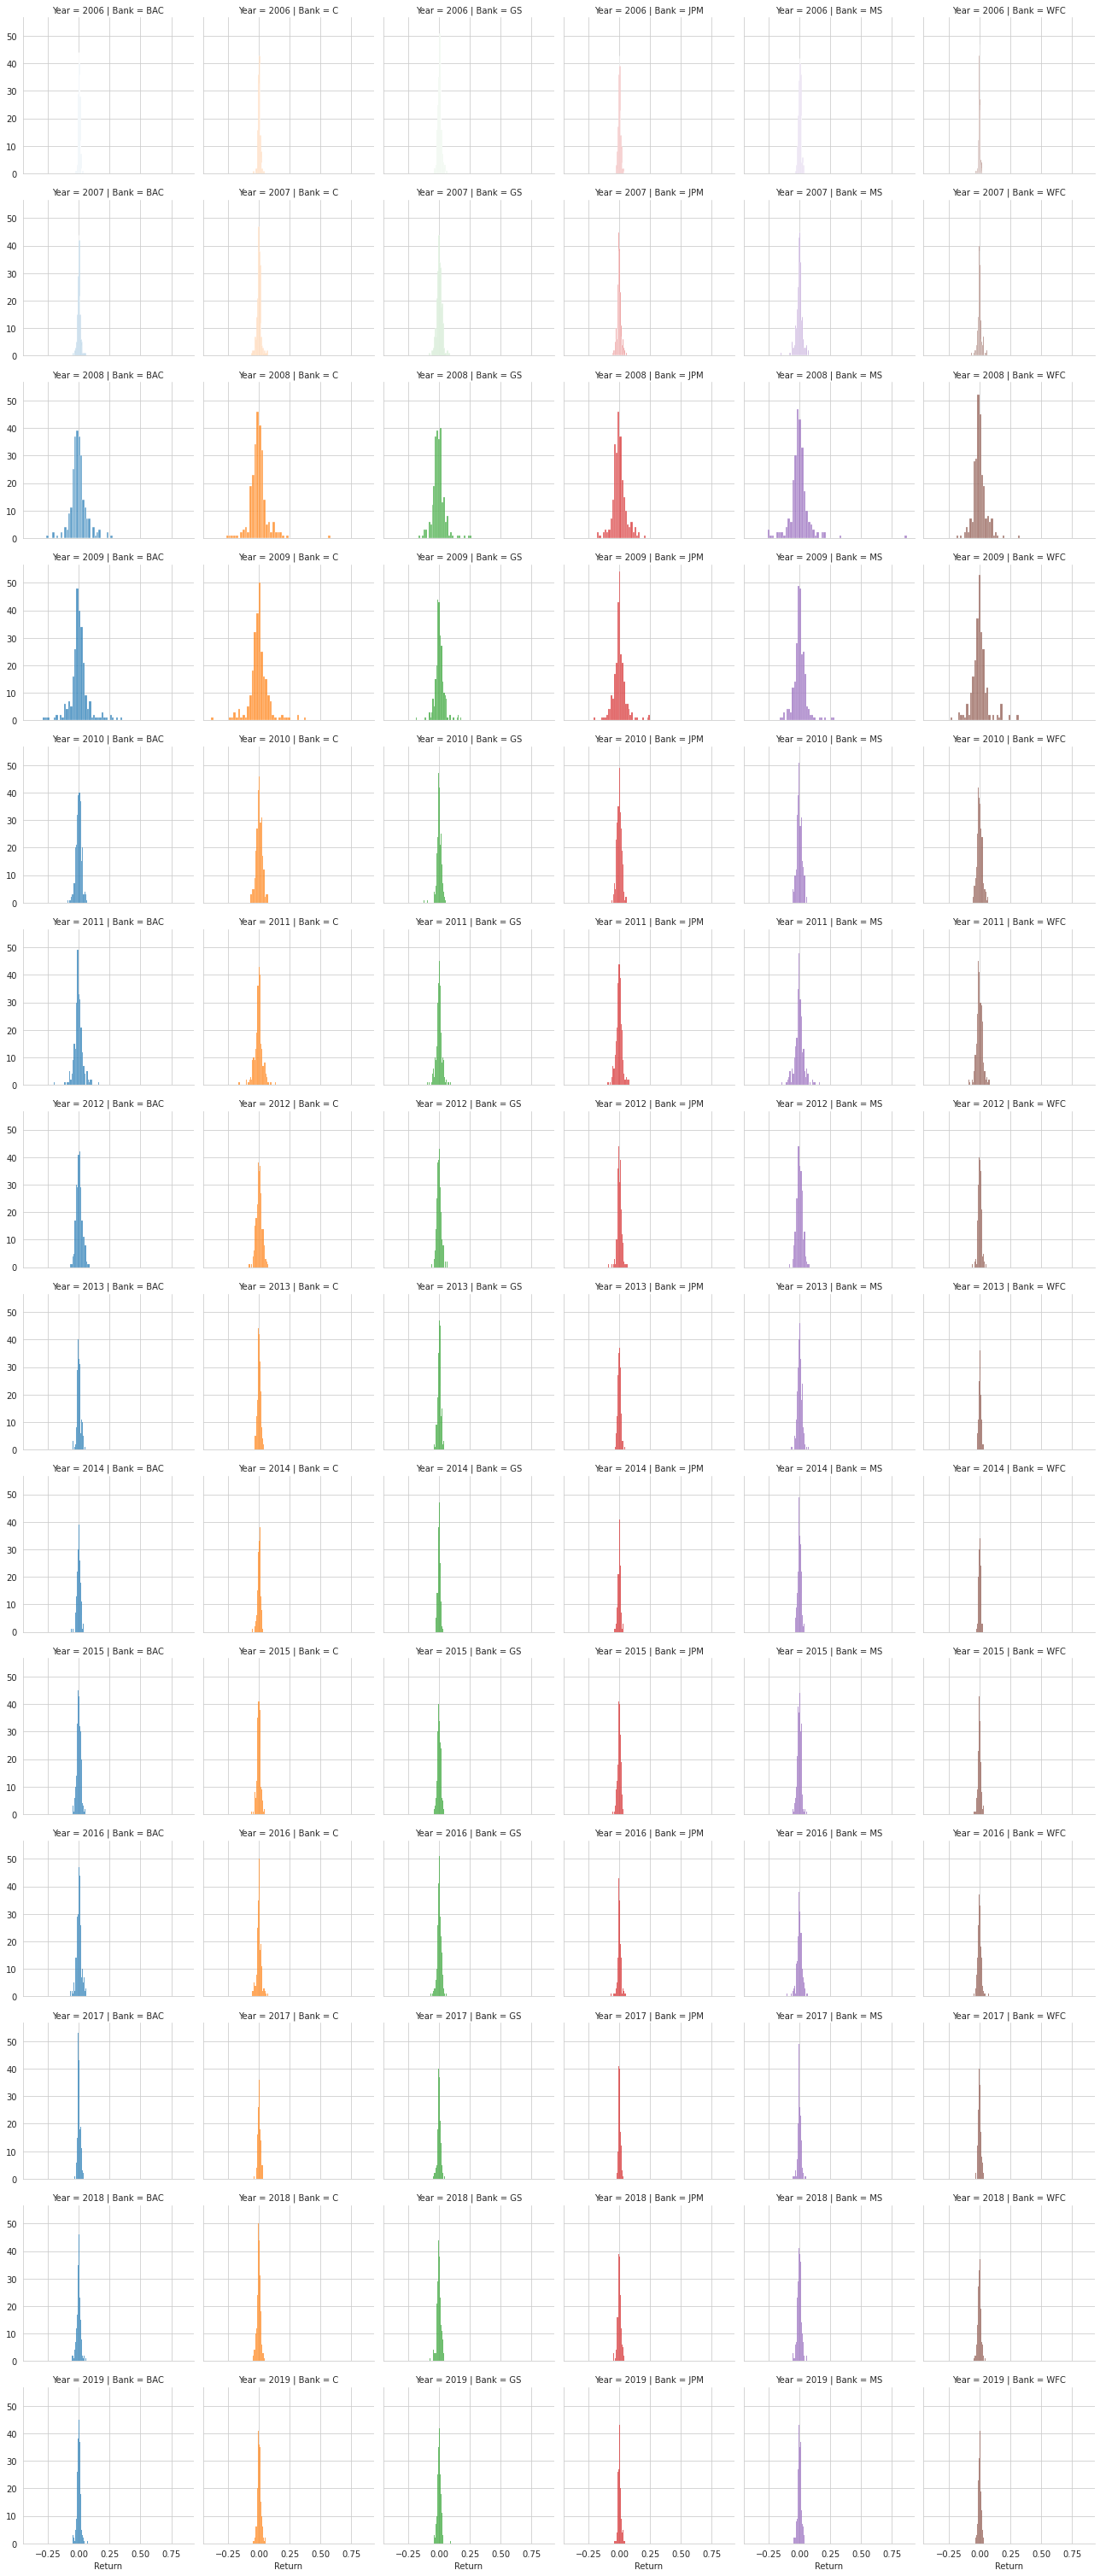

In [ ]:
# What does the distribution of the returns look like over the years?
# Make another dataset in a different format;
# We will have 4 columns (3 and we create one later called Year)
# Make one column for the date, one for the bank and one for the return of the
# bank at that date
# Reset the index (easier to make plots with one index rather than multileve
# index)
long_banks = pd.DataFrame(returns.stack()).reset_index()
long_banks.columns = ["Date", "Bank", "Return"]
# Use a lammbda function to get the bank name (the entries right now are 
# "Bank_Name Return" so remove the "Return")
long_banks["Bank"] = long_banks["Bank"].apply(lambda x: x.split()[0])
# Get the year (for facet plot)
long_banks["Year"] = pd.DatetimeIndex(long_banks["Date"]).year
# Create a plot of the returns for each bank over the 14 years of data we have
g = sns.FacetGrid(long_banks, col = "Bank",  row = "Year", hue = "Bank")
g.map(sns.histplot, "Return")
plt.show()
# We see that in 2006 & 2007, there is very low variability
# However, in 2008 & 2009, there is a lot of variability and the peaks are not 
# as concentrated as the other years 
# After that, 2010 & 2011 is better than '08 & '09 but in 2012 & 2013 do we 
# finally see the returns get back to "normal"

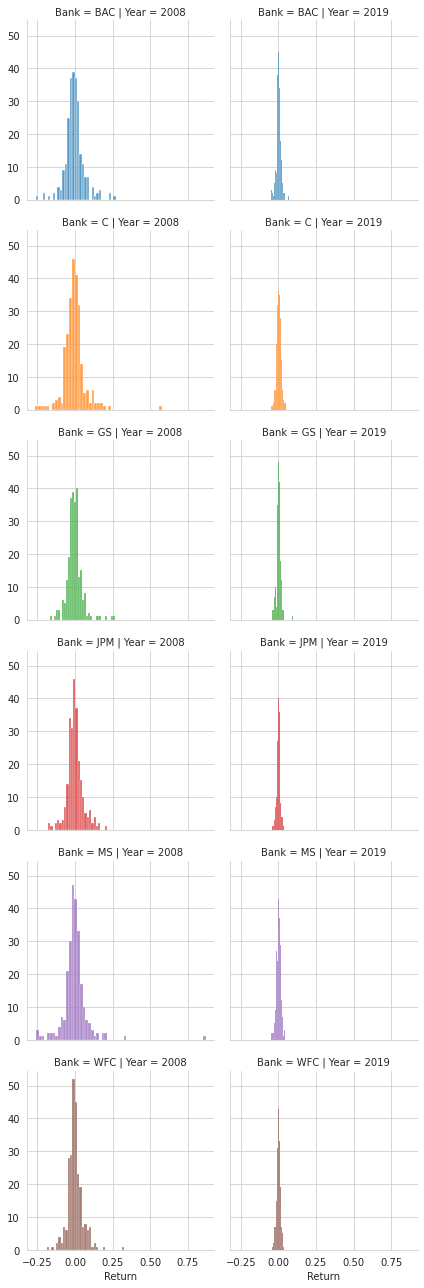

In [ ]:
# Lets compare data from 2 years (2008 and 2019) for each bank, side by side
long_banks_filtered = long_banks[(long_banks["Year"] == 2008) |
                                 (long_banks["Year"] == 2019)]
g = sns.FacetGrid(long_banks_filtered, col = "Year",  
                  row = "Bank", hue = "Bank")
g.map(sns.histplot, "Return")
plt.show()

In [ ]:
# When do the highest and lowest returns occur for each bank?
returns.idxmin()
# WOW, so they are all heavily around the financial crisis (which makes sense)
# But one thing which was unexpected is that for FOUR out of the SIX banks, the
# Minimum occurs on the same day (BAC, GS, JPM & WFC) on 2009-01-20
# On January 20, 2009 is when Barack Obama for inaugurated. 


BAC Return   2009-01-20
C Return     2009-02-27
GS Return    2009-01-20
JPM Return   2009-01-20
MS Return    2008-10-09
WFC Return   2009-01-20
dtype: datetime64[ns]

In [ ]:
# What about the max?
returns.idxmax()
# Funny thing about MS, 4 days after their lowest return they had their highest
# and for JPM the highest was the very next day

# During the financial crisis, there was a new president so there was a lot of
# changes occuring, which is why there is probably a lot of variability during
# that period. We will probably see this for all the banks when we plot the 
# trend lines for each of the banks (let's see how this changes the 7 day and
# 30 day rolling average, which we will also plot)

BAC Return   2009-04-09
C Return     2008-11-24
GS Return    2008-11-24
JPM Return   2009-01-21
MS Return    2008-10-13
WFC Return   2008-07-16
dtype: datetime64[ns]

In [ ]:
# What does the overall SD of each stock look like 
# Look at SD for the whole dataset, and also for 2007 - 2010
returns.std()
# BAC, C & MS have a relatively high std compared to GS, JPM & WFC

BAC Return    0.032158
C Return      0.033750
GS Return     0.022946
JPM Return    0.024401
MS Return     0.033176
WFC Return    0.026551
dtype: float64

In [ ]:
# Let's take a look at the std over 4 years
a = returns.loc["2007-01-01":"2007-12-31"].std()
b = returns.loc["2008-01-01":"2008-12-31"].std()
c = returns.loc["2009-01-01":"2009-12-31"].std()
d = returns.loc["2010-01-01":"2010-12-31"].std()

sd = pd.concat([a, b, c, d], axis = 1, keys = [2007, 2008, 2009, 2010])
# As we can see, the std is pretty low in 2007, but increases a lot in 
# 2008 & 2009 (which we expect) and begins to settle down again in 2010
sd

2007      2008      2009      2010
BAC Return  0.013765  0.062934  0.077839  0.023139
C Return    0.018278  0.073523  0.079363  0.023955
GS Return   0.021849  0.050015  0.038187  0.019344
JPM Return  0.016821  0.053134  0.051184  0.019352
MS Return   0.024866  0.087604  0.051127  0.021021
WFC Return  0.016990  0.052439  0.066828  0.021313

In [ ]:
# What does the std look like in the most recent full year (2019)
returns.loc["2019-01-01":"2019-12-31"].std()
# They are all very low 

BAC Return    0.014566
C Return      0.015354
GS Return     0.014890
JPM Return    0.011869
MS Return     0.014701
WFC Return    0.012450
dtype: float64

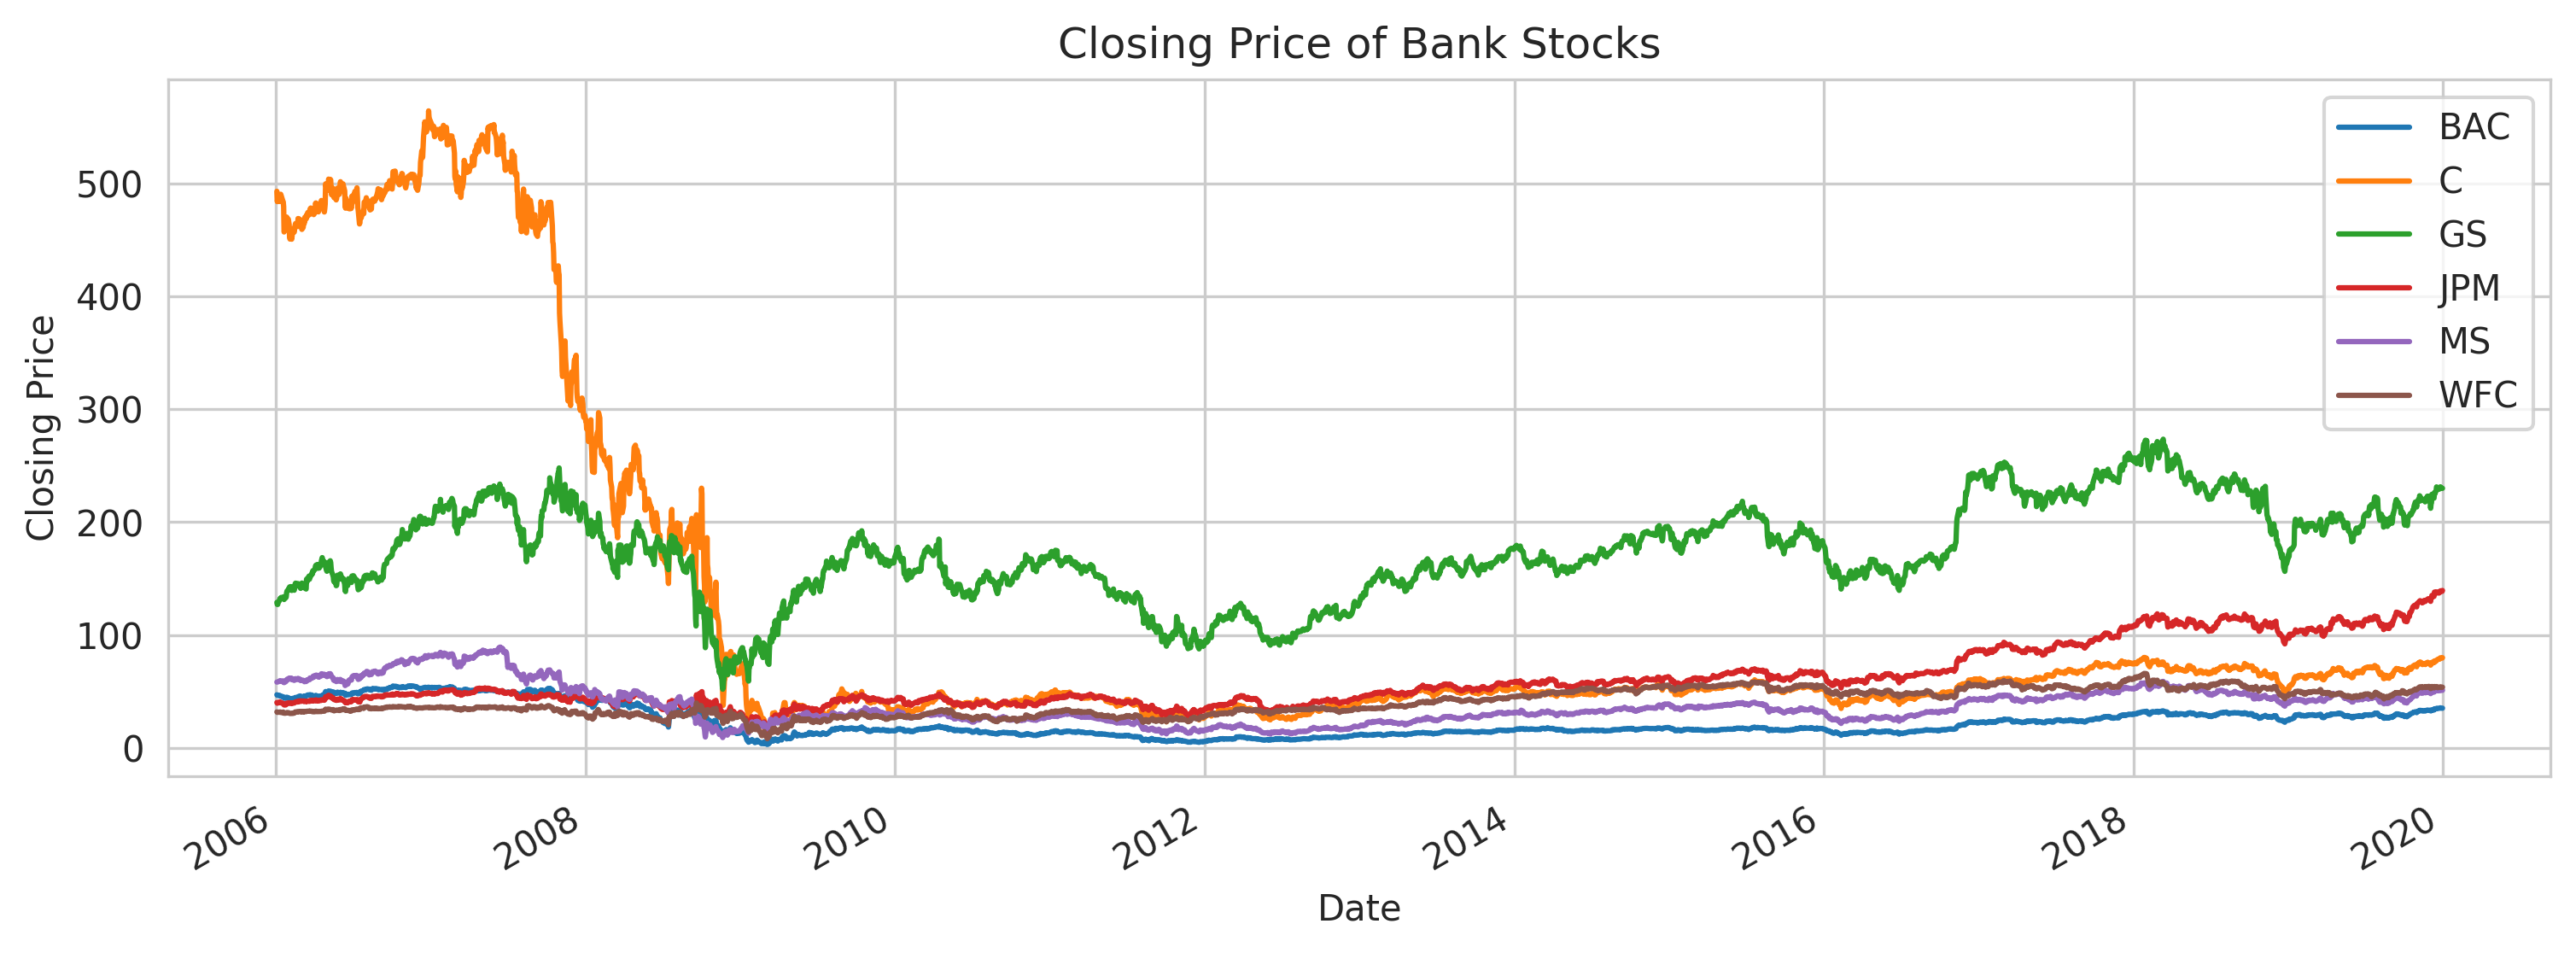

In [ ]:
# Let's take a look at the closing price for each stock
# How does it vary over time
# CitiGroup crashed quite a bit in 2008 and didn't really recover

# Resize the figure (and change the dpi to make it bigger/nicer)
plt.figure(figsize = (12, 4), dpi = 300)
# Run a for loop that will go over each ticker symbol (bank) and plot the Close
# price for each bank
for ticker in tickers:
  # Plot the data and add a label for the ticker
  bank_stocks[ticker]["Close"].plot(label = ticker)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing Price of Bank Stocks")
plt.show()

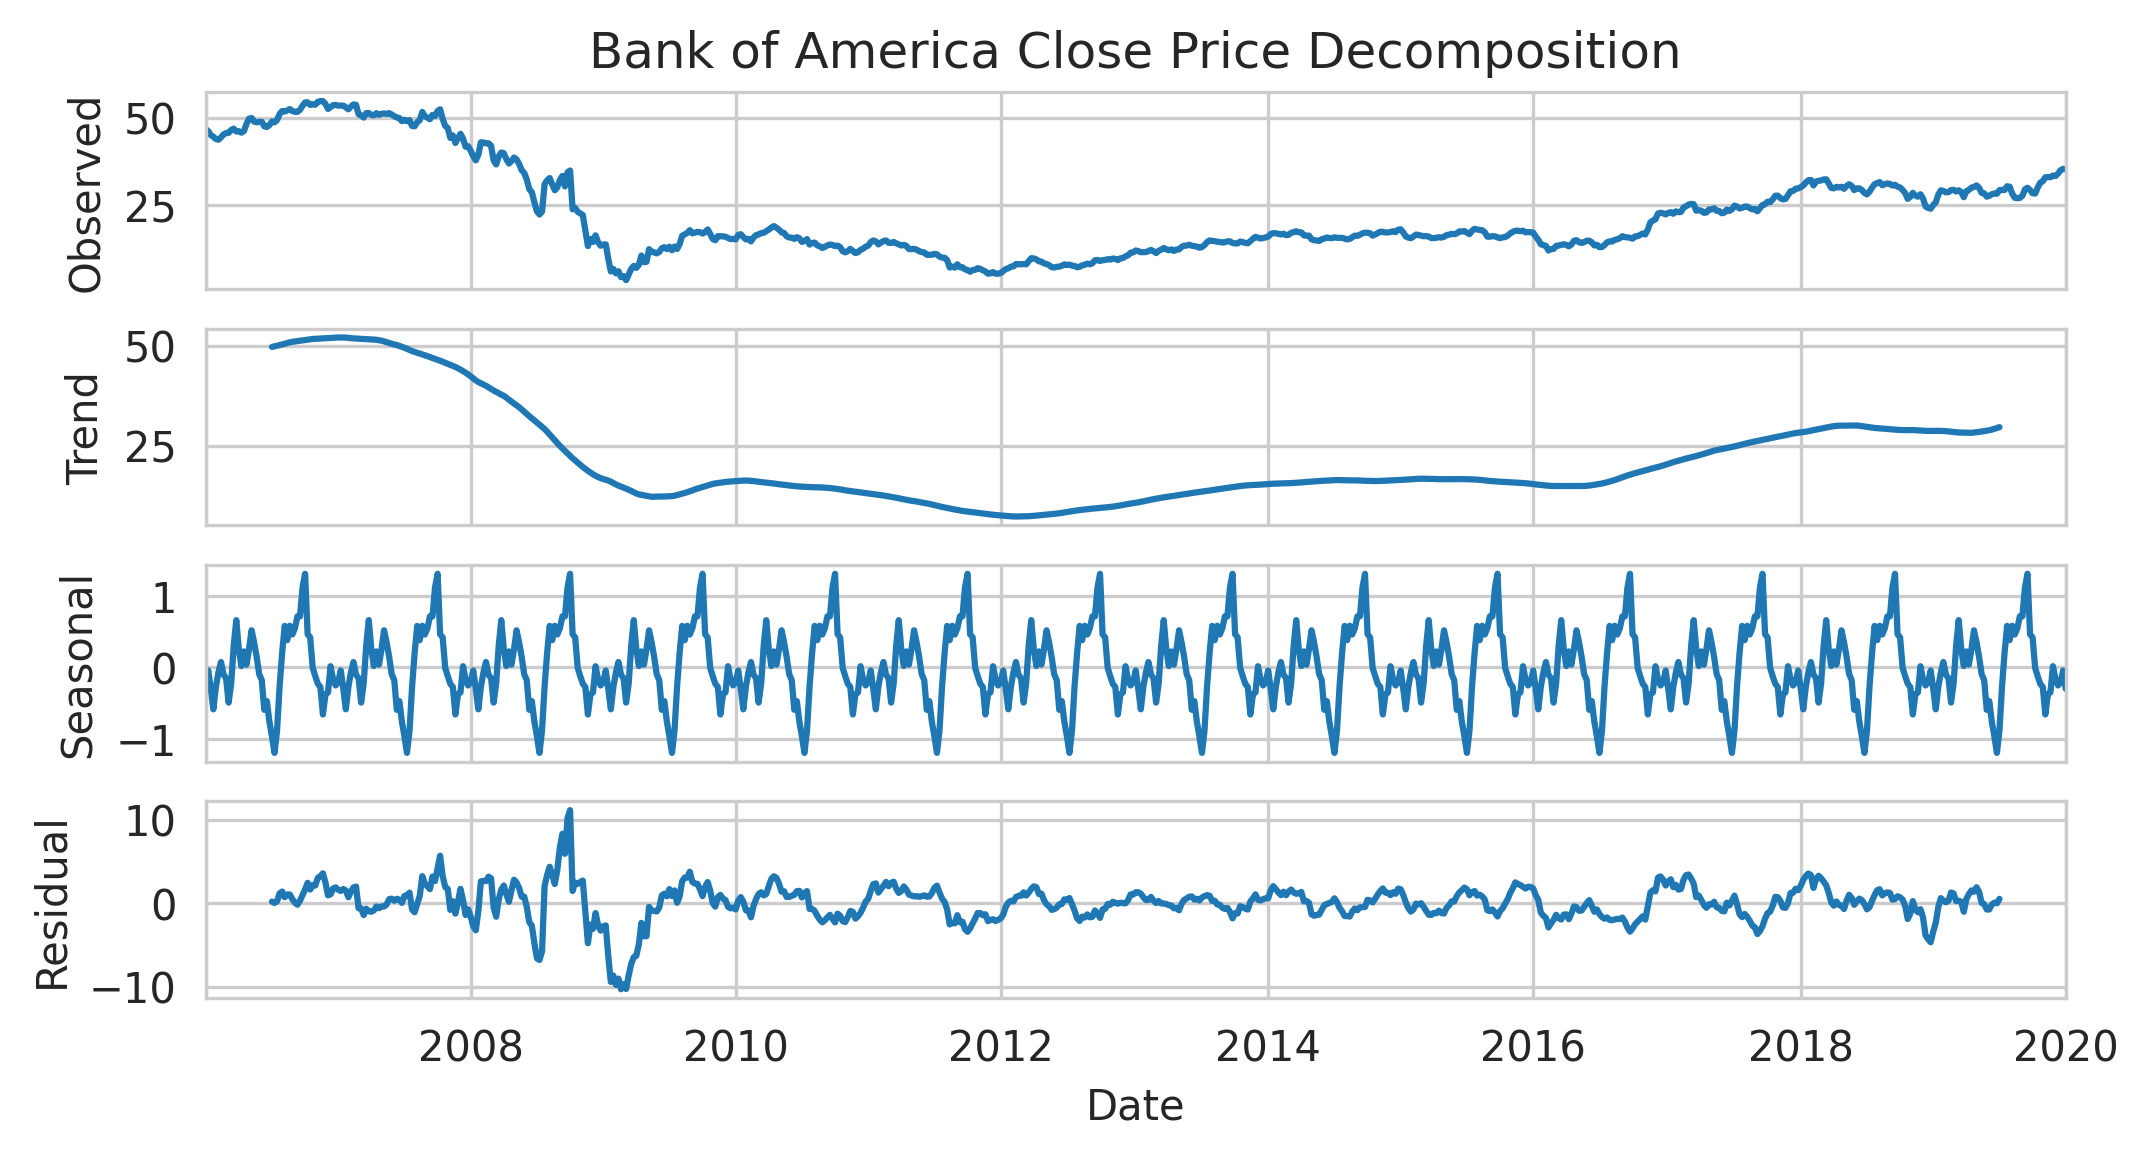

In [ ]:
# Let's see a breakdown of each Bank's trend
# BAC
# We will make the period a week (this will help us get rid of some NAs) but 
# will also make the format of the DataFrame a bit nicer
bac = bank_stocks["BAC"]["Close"].resample('W').mean()
# Decompose the trend (into an additive model)
decomposition = sm.tsa.seasonal_decompose(bac, model = "additive")
# Create the figure and axes (using the object oriented method)
# Note: We could have simply called the method .plot() on our decomposition 
# dataframe but that would not allow us to make any changes 
# So we would not be able to to change the figure size, dpi or color of the 
# plots
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel("Observed")
axes[0].set_title("Bank of America Close Price Decomposition")
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel("Residual")
plt.show()

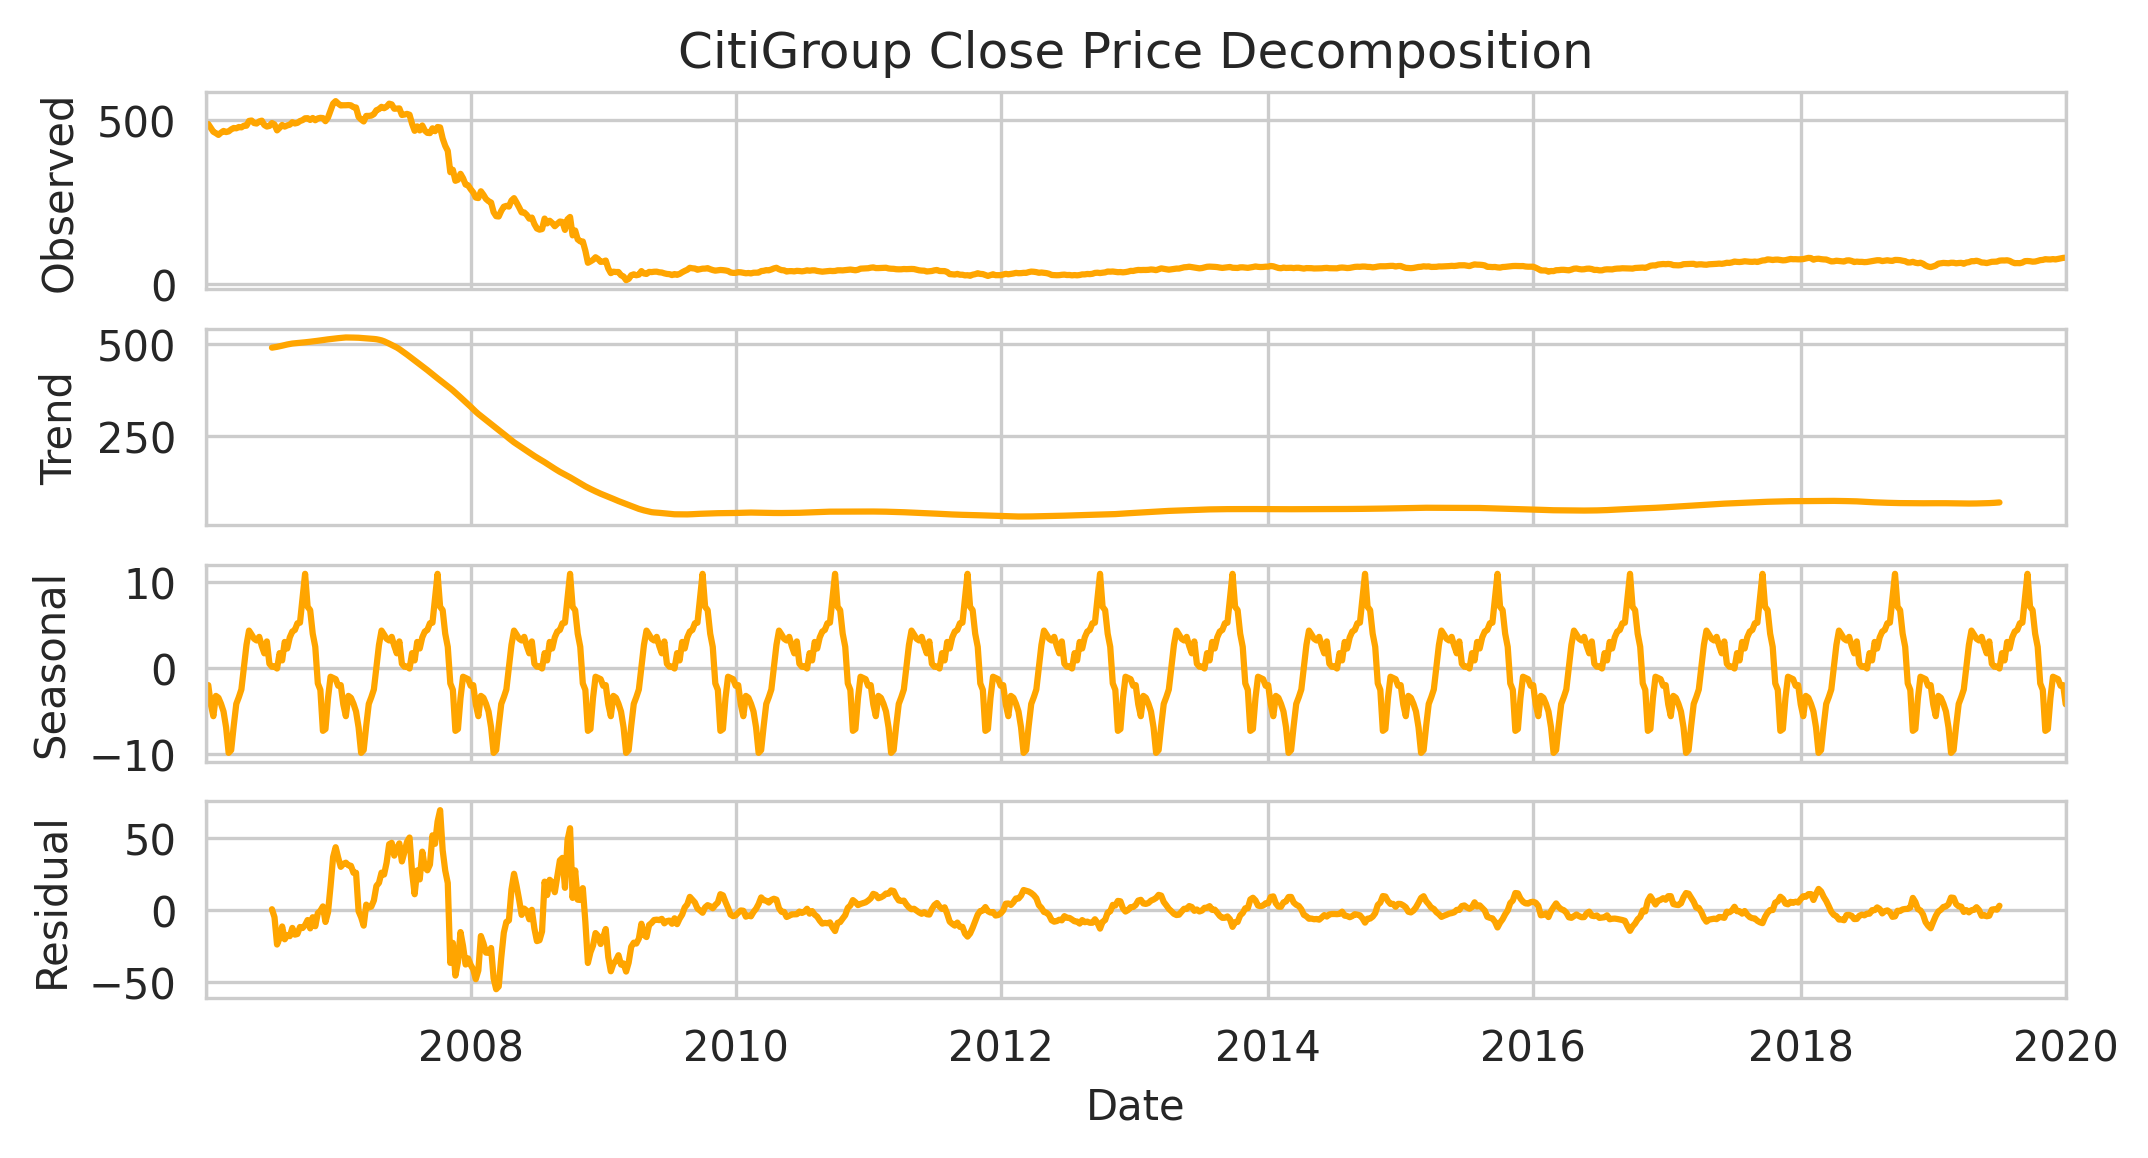

In [ ]:
# C
c = bank_stocks["C"]["Close"].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(c, model = "additive")
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False, color = "orange")
axes[0].set_ylabel("Observed")
axes[0].set_title("CitiGroup Close Price Decomposition")
decomposition.trend.plot(ax=axes[1], legend=False, color = "orange")
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False, color = "orange")
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False, color = "orange")
axes[3].set_ylabel("Residual")
plt.show()

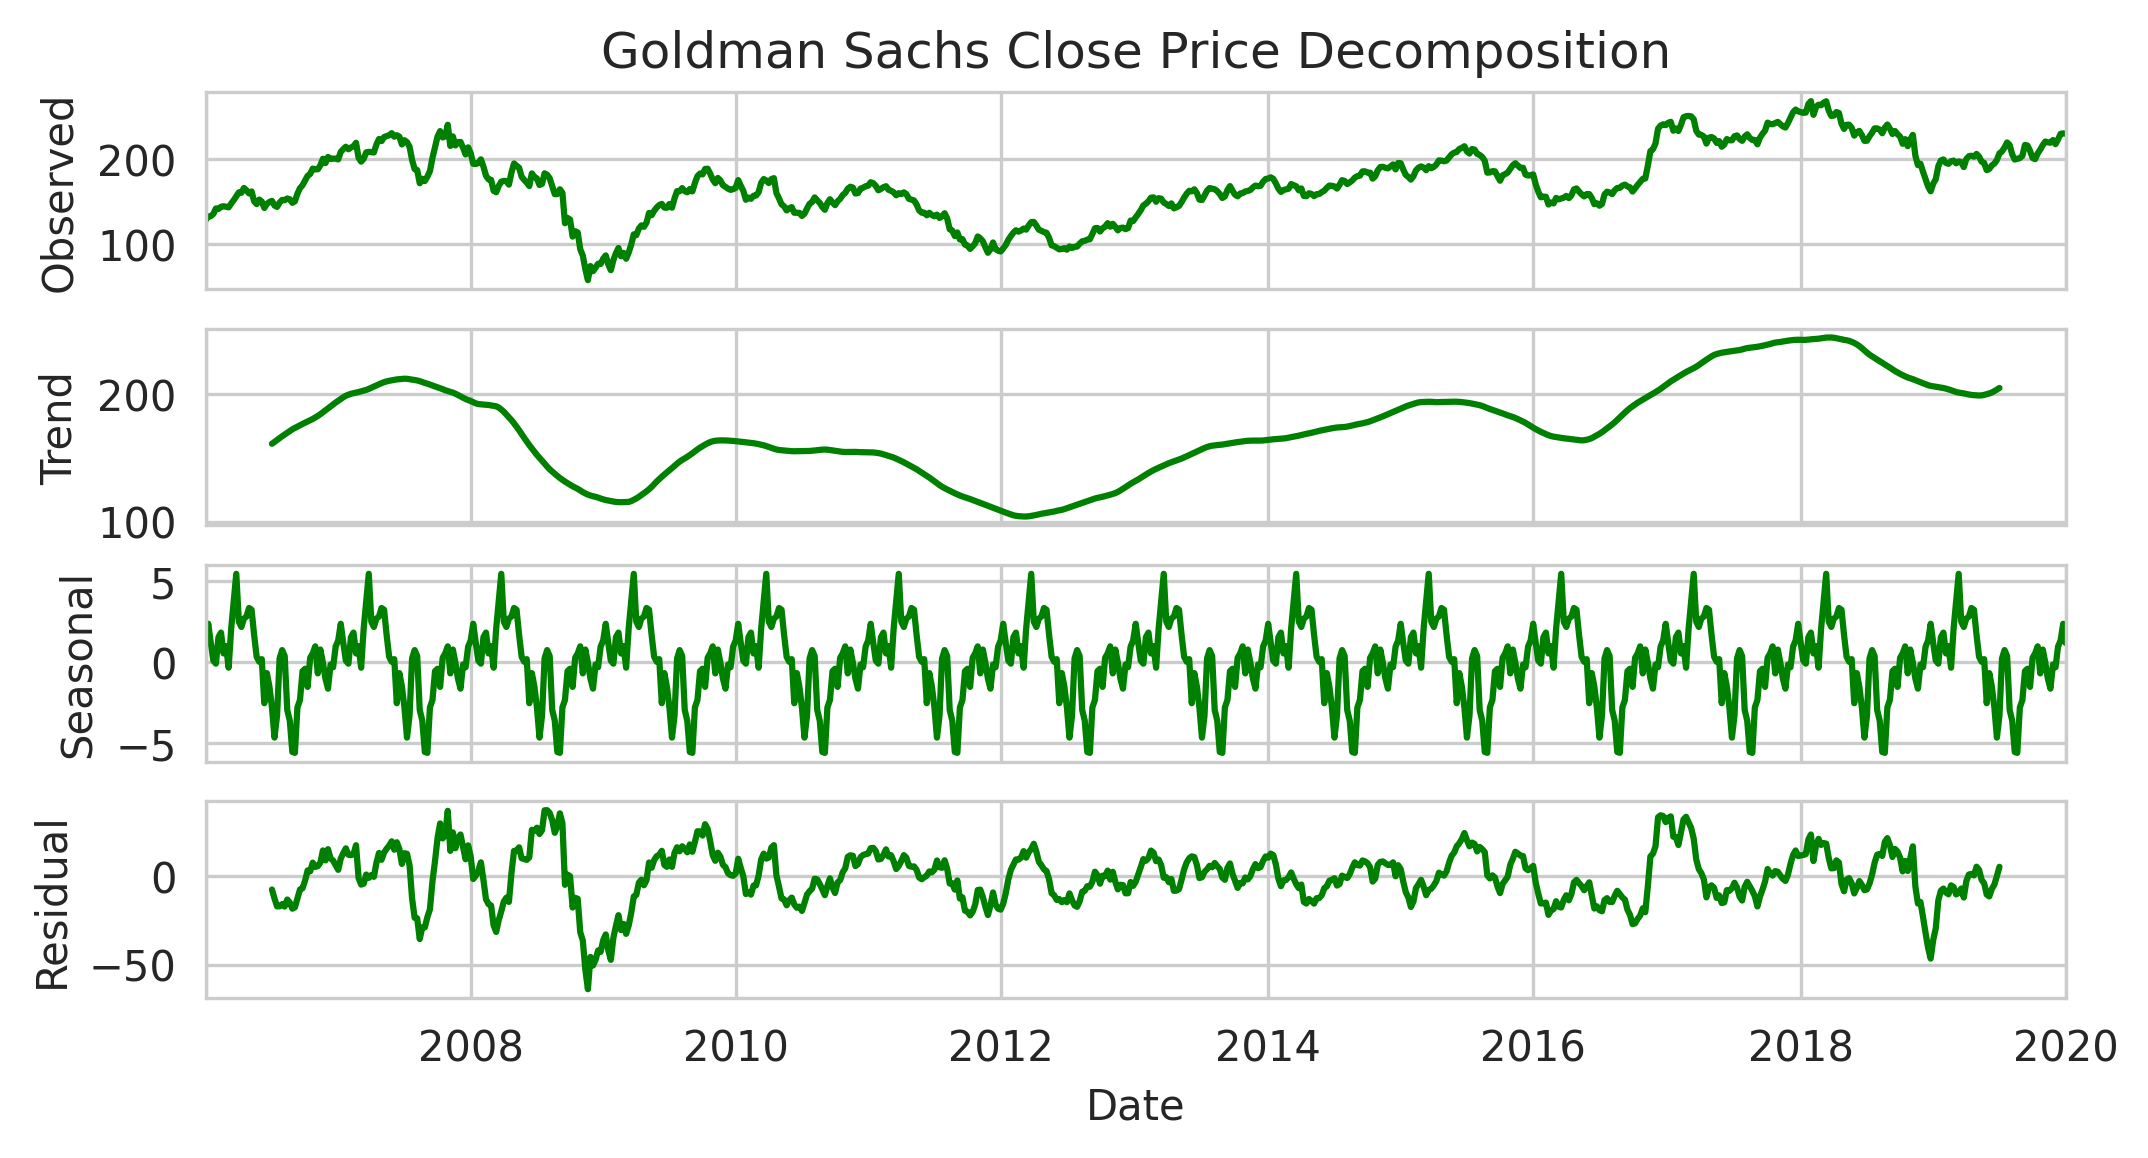

In [ ]:
# GS
gs = bank_stocks["GS"]["Close"].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(gs, model = "additive")
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False, color = "green")
axes[0].set_ylabel("Observed")
axes[0].set_title("Goldman Sachs Close Price Decomposition")
decomposition.trend.plot(ax=axes[1], legend=False, color = "green")
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False, color = "green")
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False, color = "green")
axes[3].set_ylabel("Residual")
plt.show()

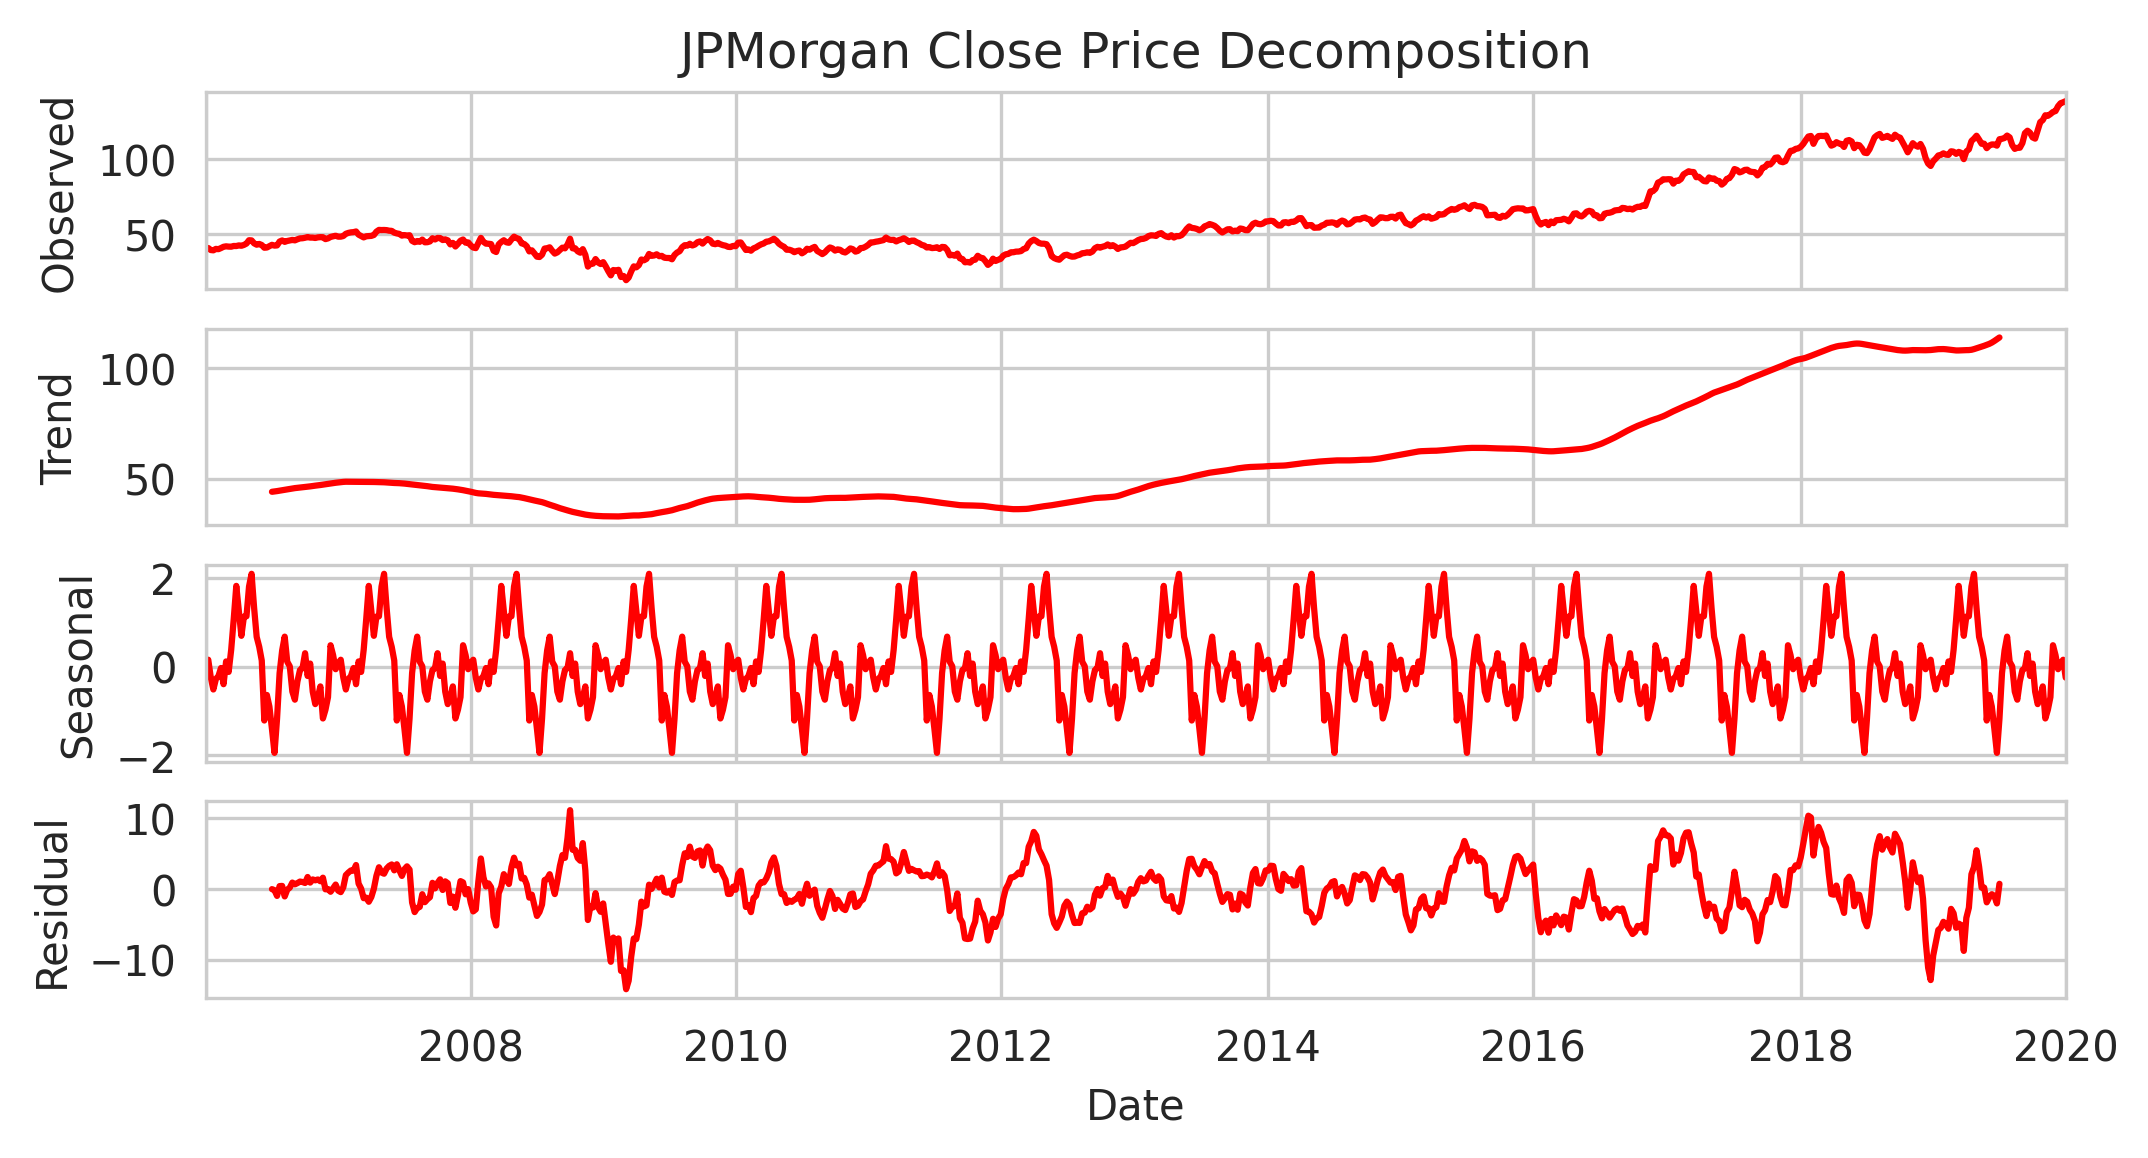

In [ ]:
# JPM
jpm = bank_stocks["JPM"]["Close"].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(jpm, model = "additive")
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False, color = "red")
axes[0].set_ylabel("Observed")
axes[0].set_title("JPMorgan Close Price Decomposition")
decomposition.trend.plot(ax=axes[1], legend=False, color = "red")
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False, color = "red")
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False, color = "red")
axes[3].set_ylabel("Residual")
plt.show()

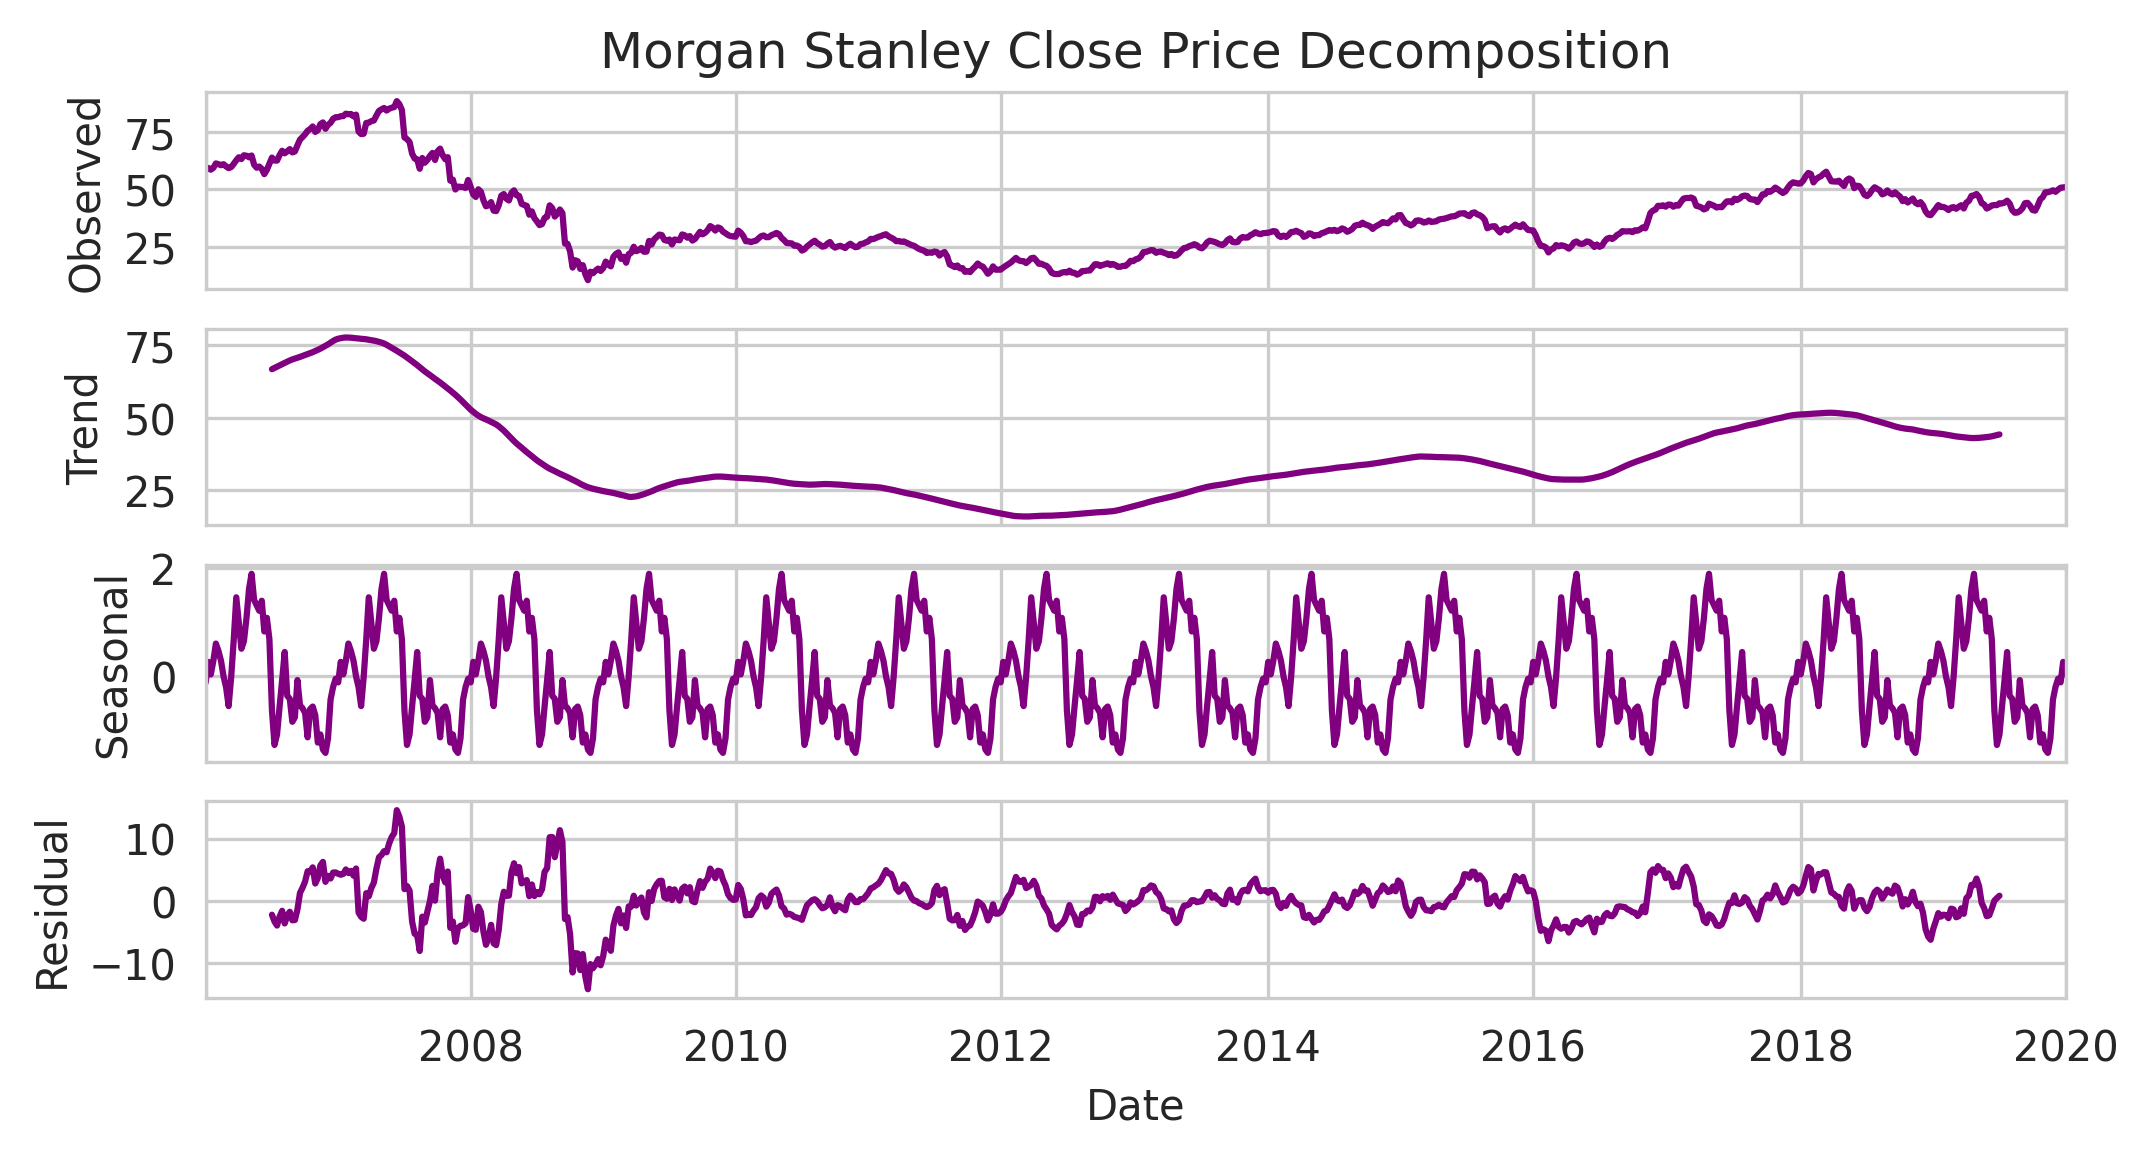

In [ ]:
# MS
ms = bank_stocks["MS"]["Close"].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(ms, model = "additive")
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False, color = "purple")
axes[0].set_ylabel("Observed")
axes[0].set_title("Morgan Stanley Close Price Decomposition")
decomposition.trend.plot(ax=axes[1], legend=False, color = "purple")
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False, color = "purple")
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False, color = "purple")
axes[3].set_ylabel("Residual")
plt.show()

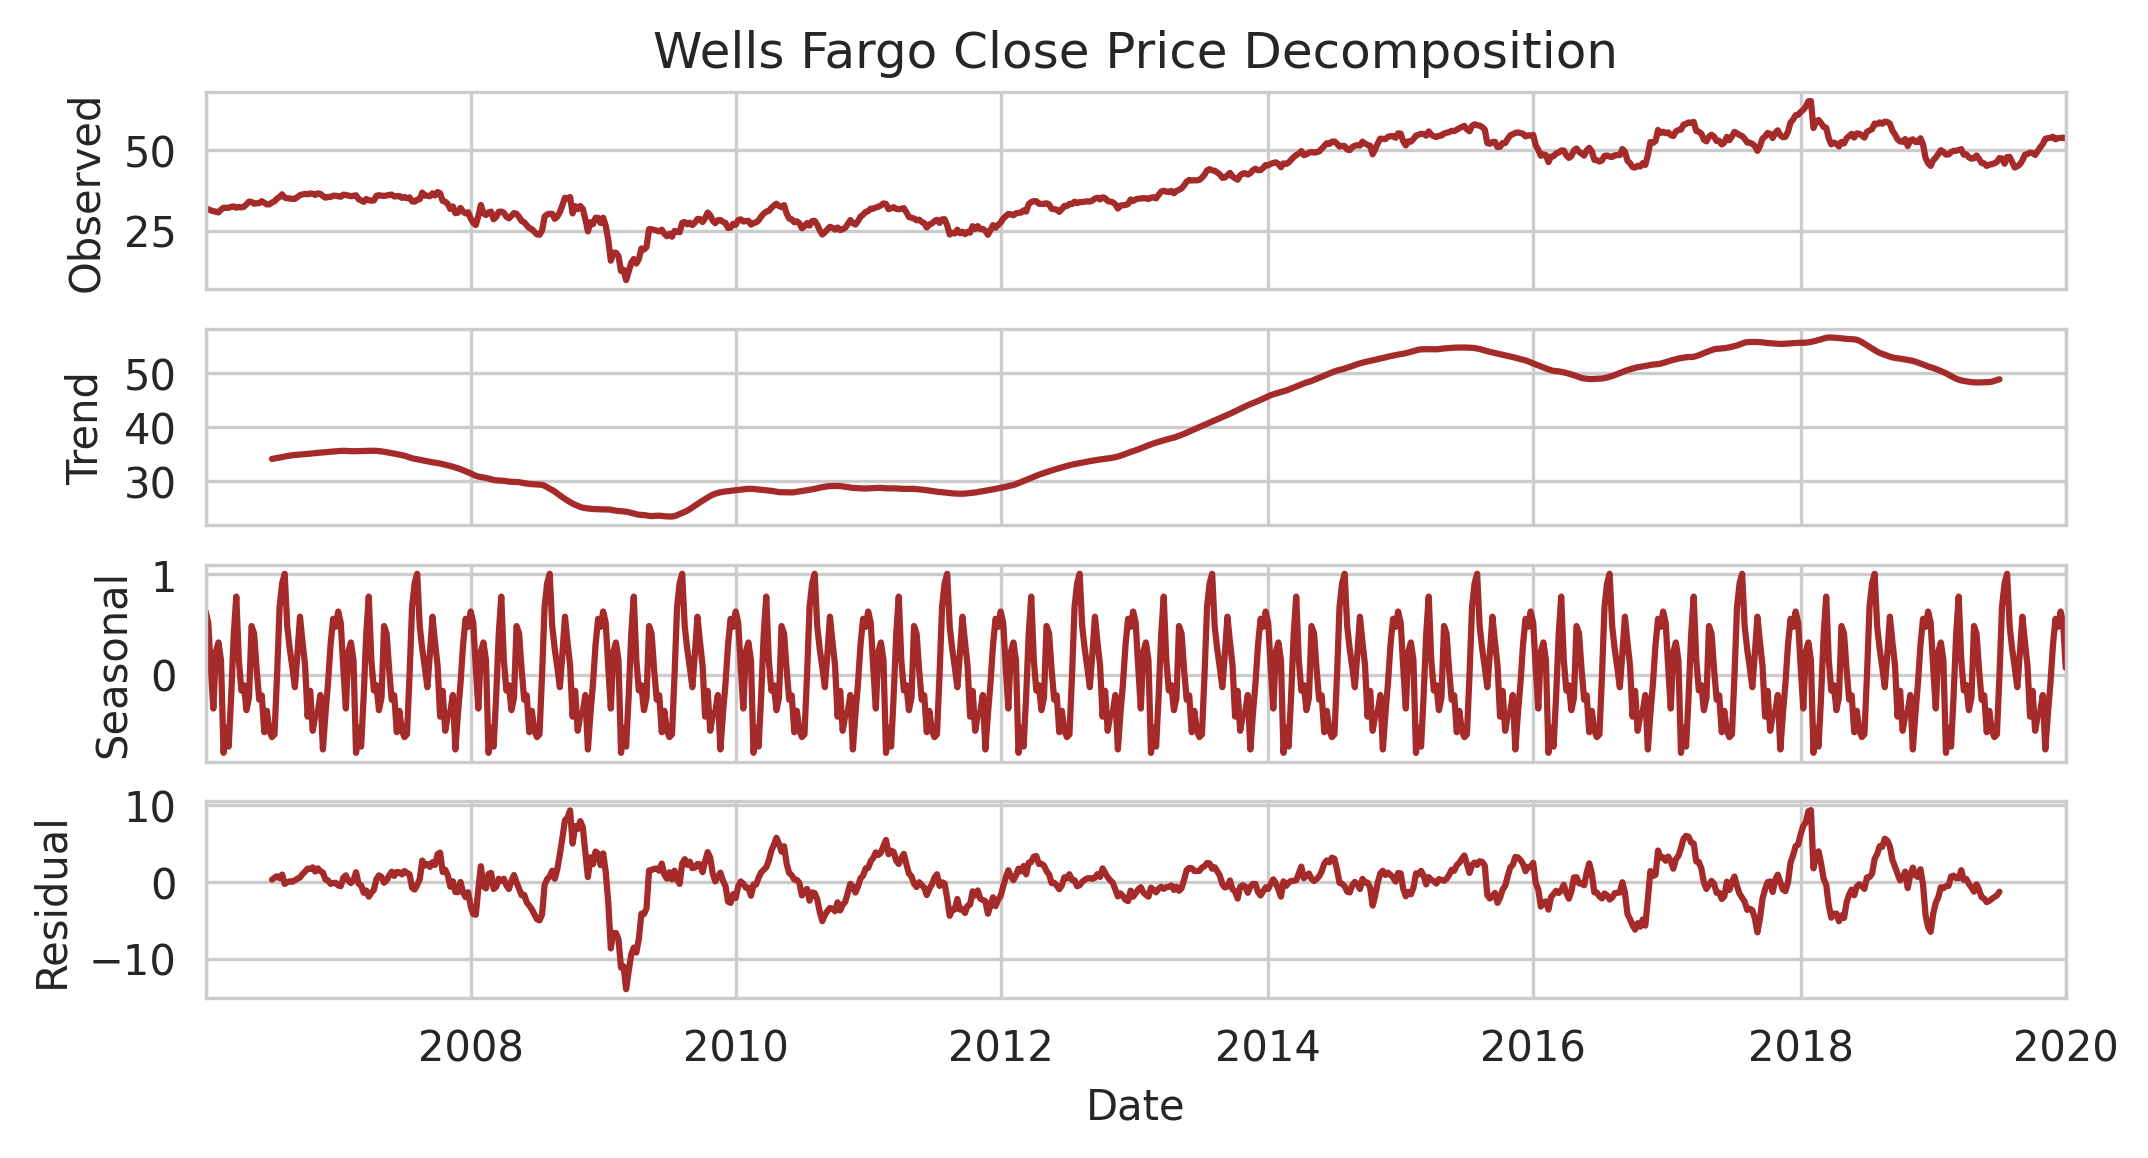

In [ ]:
# WFC
wfc = bank_stocks["WFC"]["Close"].resample('W').mean()
decomposition = sm.tsa.seasonal_decompose(wfc, model = "additive")
fig, axes = plt.subplots(4, 1, sharex=True, figsize = (8, 4), dpi = 300)
decomposition.observed.plot(ax=axes[0], legend=False, color = "brown")
axes[0].set_ylabel("Observed")
axes[0].set_title("Wells Fargo Close Price Decomposition")
decomposition.trend.plot(ax=axes[1], legend=False, color = "brown")
axes[1].set_ylabel("Trend")
decomposition.seasonal.plot(ax=axes[2], legend=False, color = "brown")
axes[2].set_ylabel("Seasonal")
decomposition.resid.plot(ax=axes[3], legend=False, color = "brown")
axes[3].set_ylabel("Residual")
plt.show()

**What do we see from those plots?**  
The first time that is noticeable from the trend is all of them take a dip in 2008-2009. Some of them, like WFC, recover but some of them, like C, don't. We also see that some banks have multiple dips. Most of them aren't too bad but in the case of GS, it is quite a large dip. It should be noted that the seasonal trend is negligible since when we take a look at the y-axes, the values are very small will often get overshadowed by the Residual.

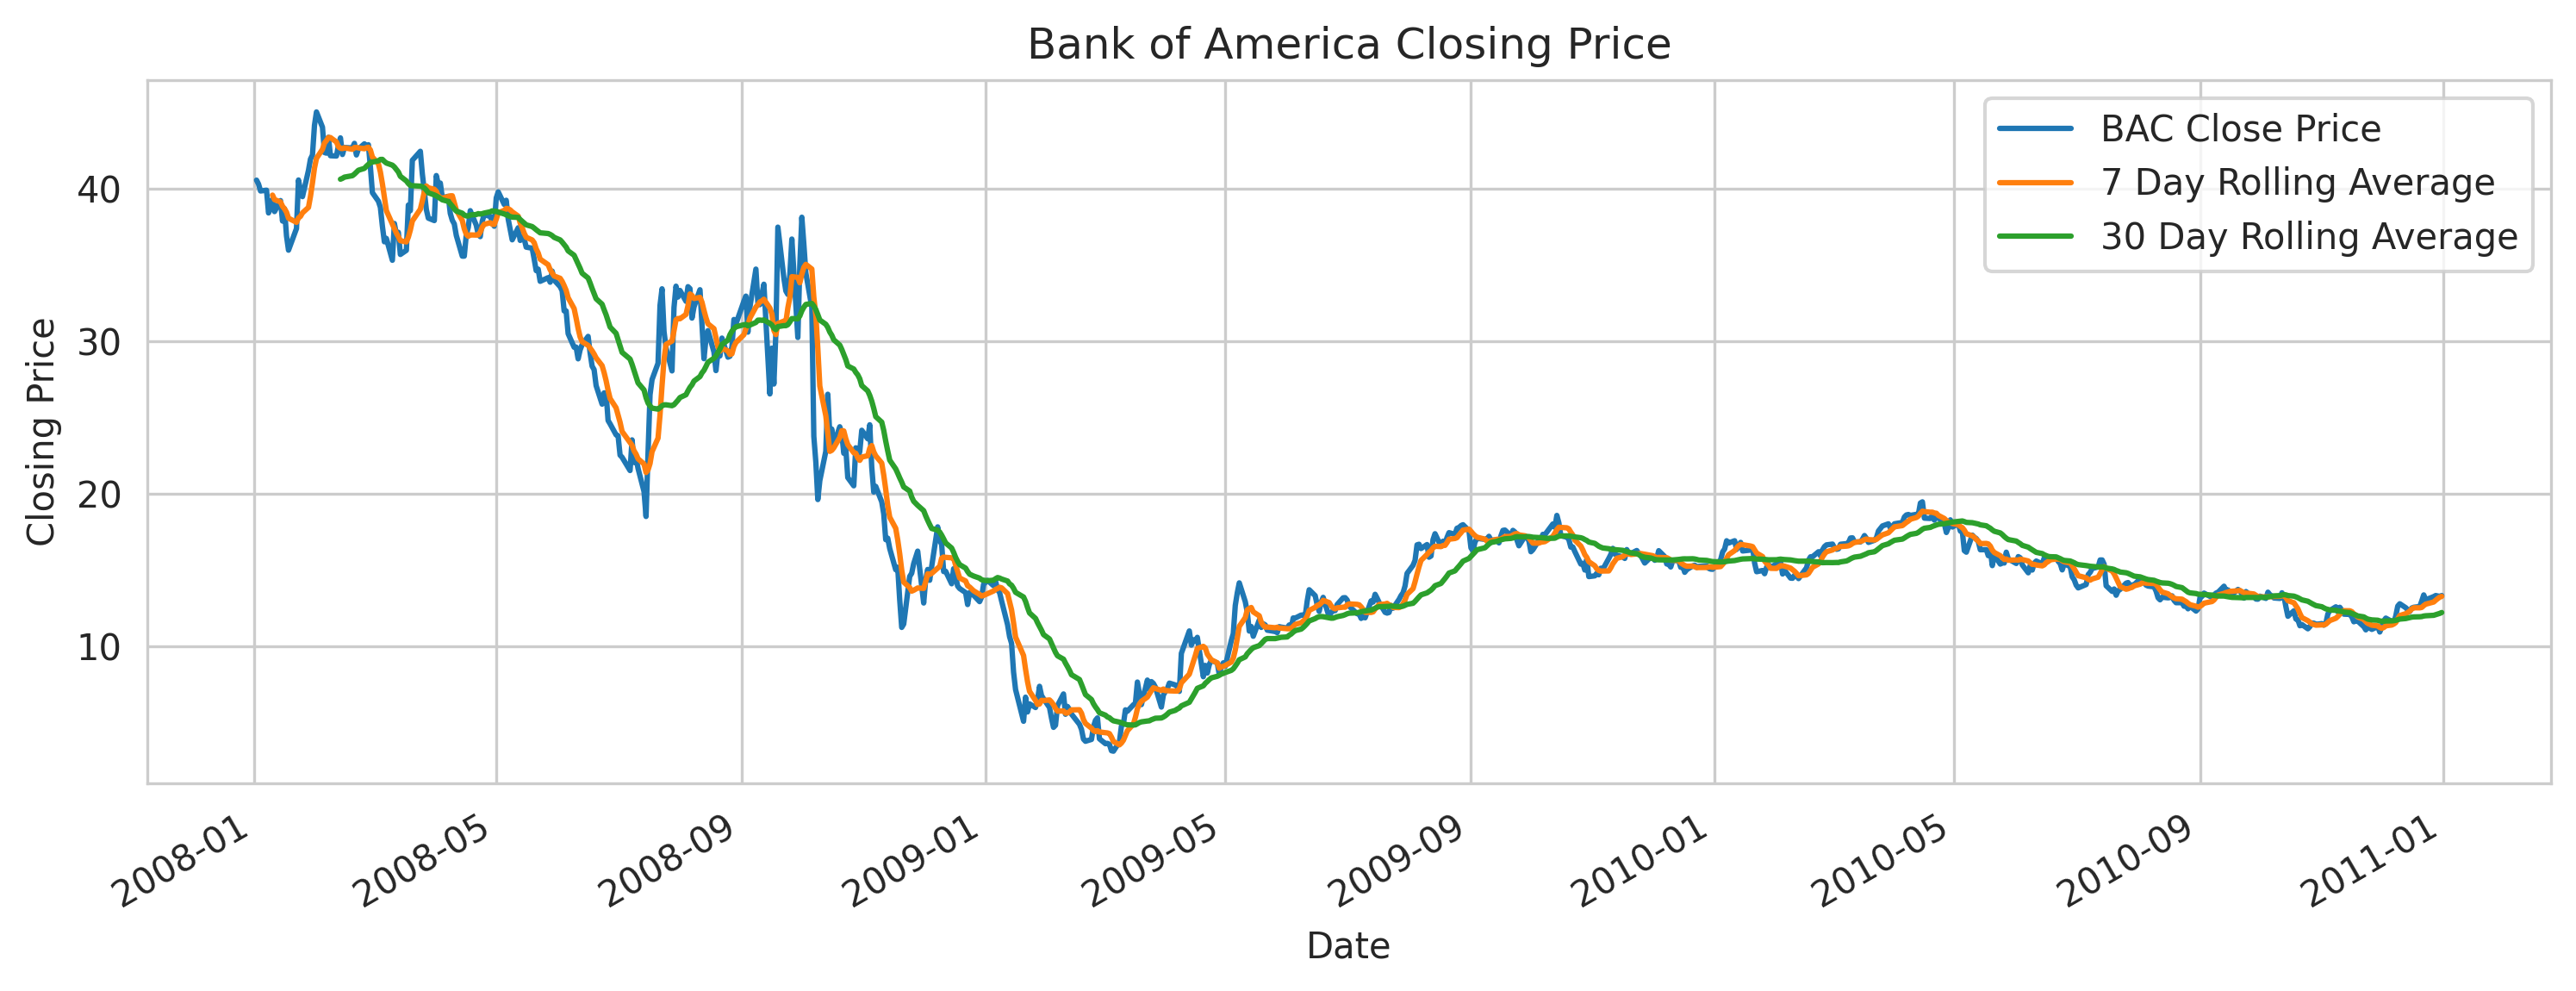

In [ ]:
# For most of these banks, there was a lot of variability in 2008 & 2009
# So, let's take a look at the 30 day and 7 day rolling average during that 
# time period
# Will also add 2010 just so we see how the begin to recover
# BAC 
# Create the figure and specify the size and dpi
plt.figure(figsize = (12, 4), dpi = 300)
# Plot the Closing prices
bank_stocks["BAC"]["Close"].loc["2008-01-01":"2011-01-01"].\
  plot(label = "BAC Close Price")
# We use the rolling() function to create a 7 & 30 day rolling average
bank_stocks["BAC"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 7).mean().plot(label = "7 Day Rolling Average")
bank_stocks["BAC"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 30).mean().plot(label = "30 Day Rolling Average")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Bank of America Closing Price")
plt.show()

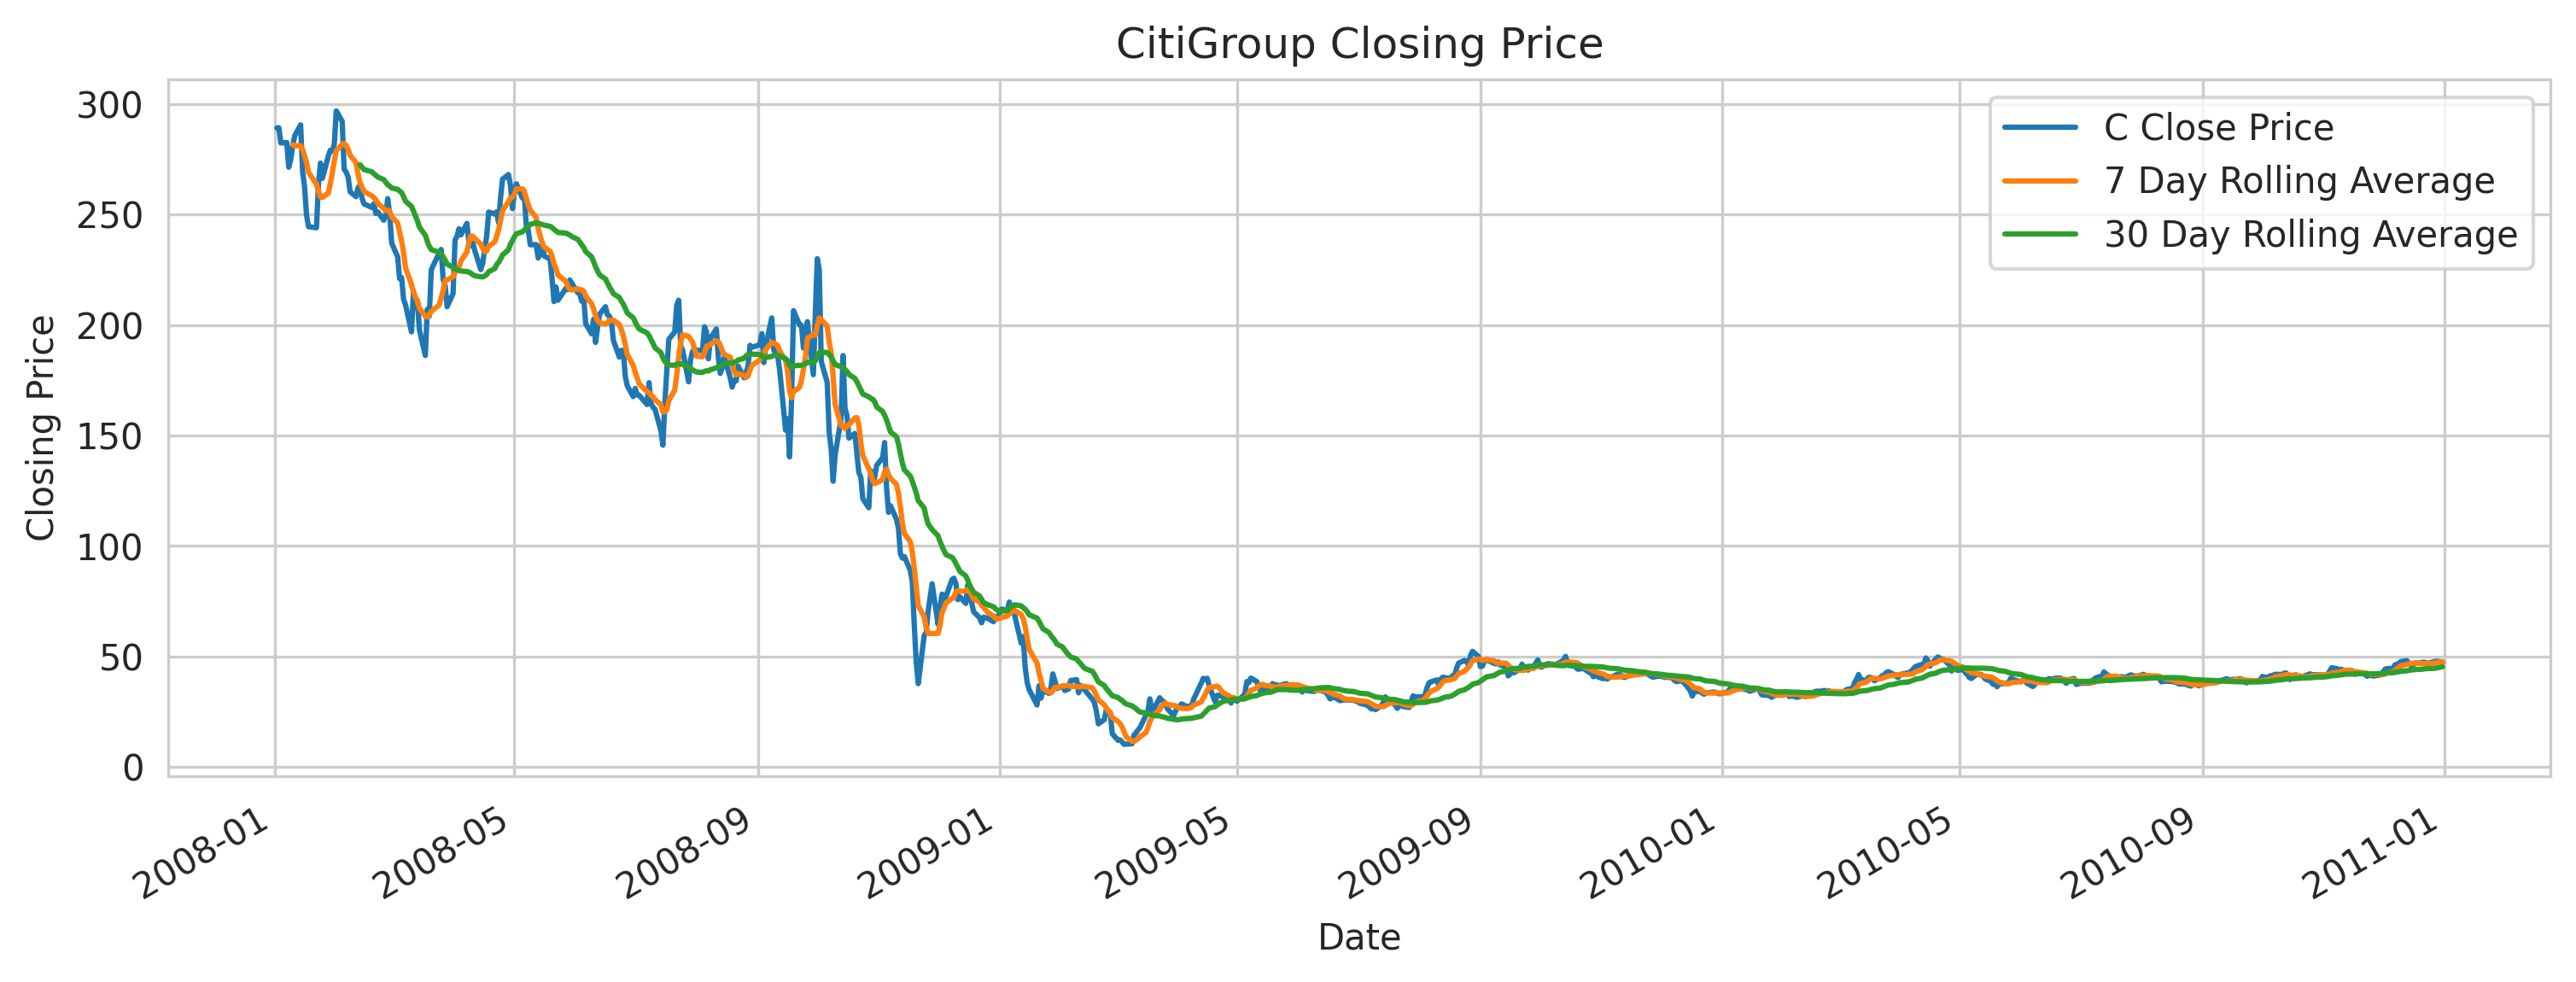

In [ ]:
# C
plt.figure(figsize = (12, 4), dpi = 300)
bank_stocks["C"]["Close"].loc["2008-01-01":"2011-01-01"].\
  plot(label = "C Close Price")
bank_stocks["C"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 7).mean().plot(label = "7 Day Rolling Average")
bank_stocks["C"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 30).mean().plot(label = "30 Day Rolling Average")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("CitiGroup Closing Price")
plt.show()

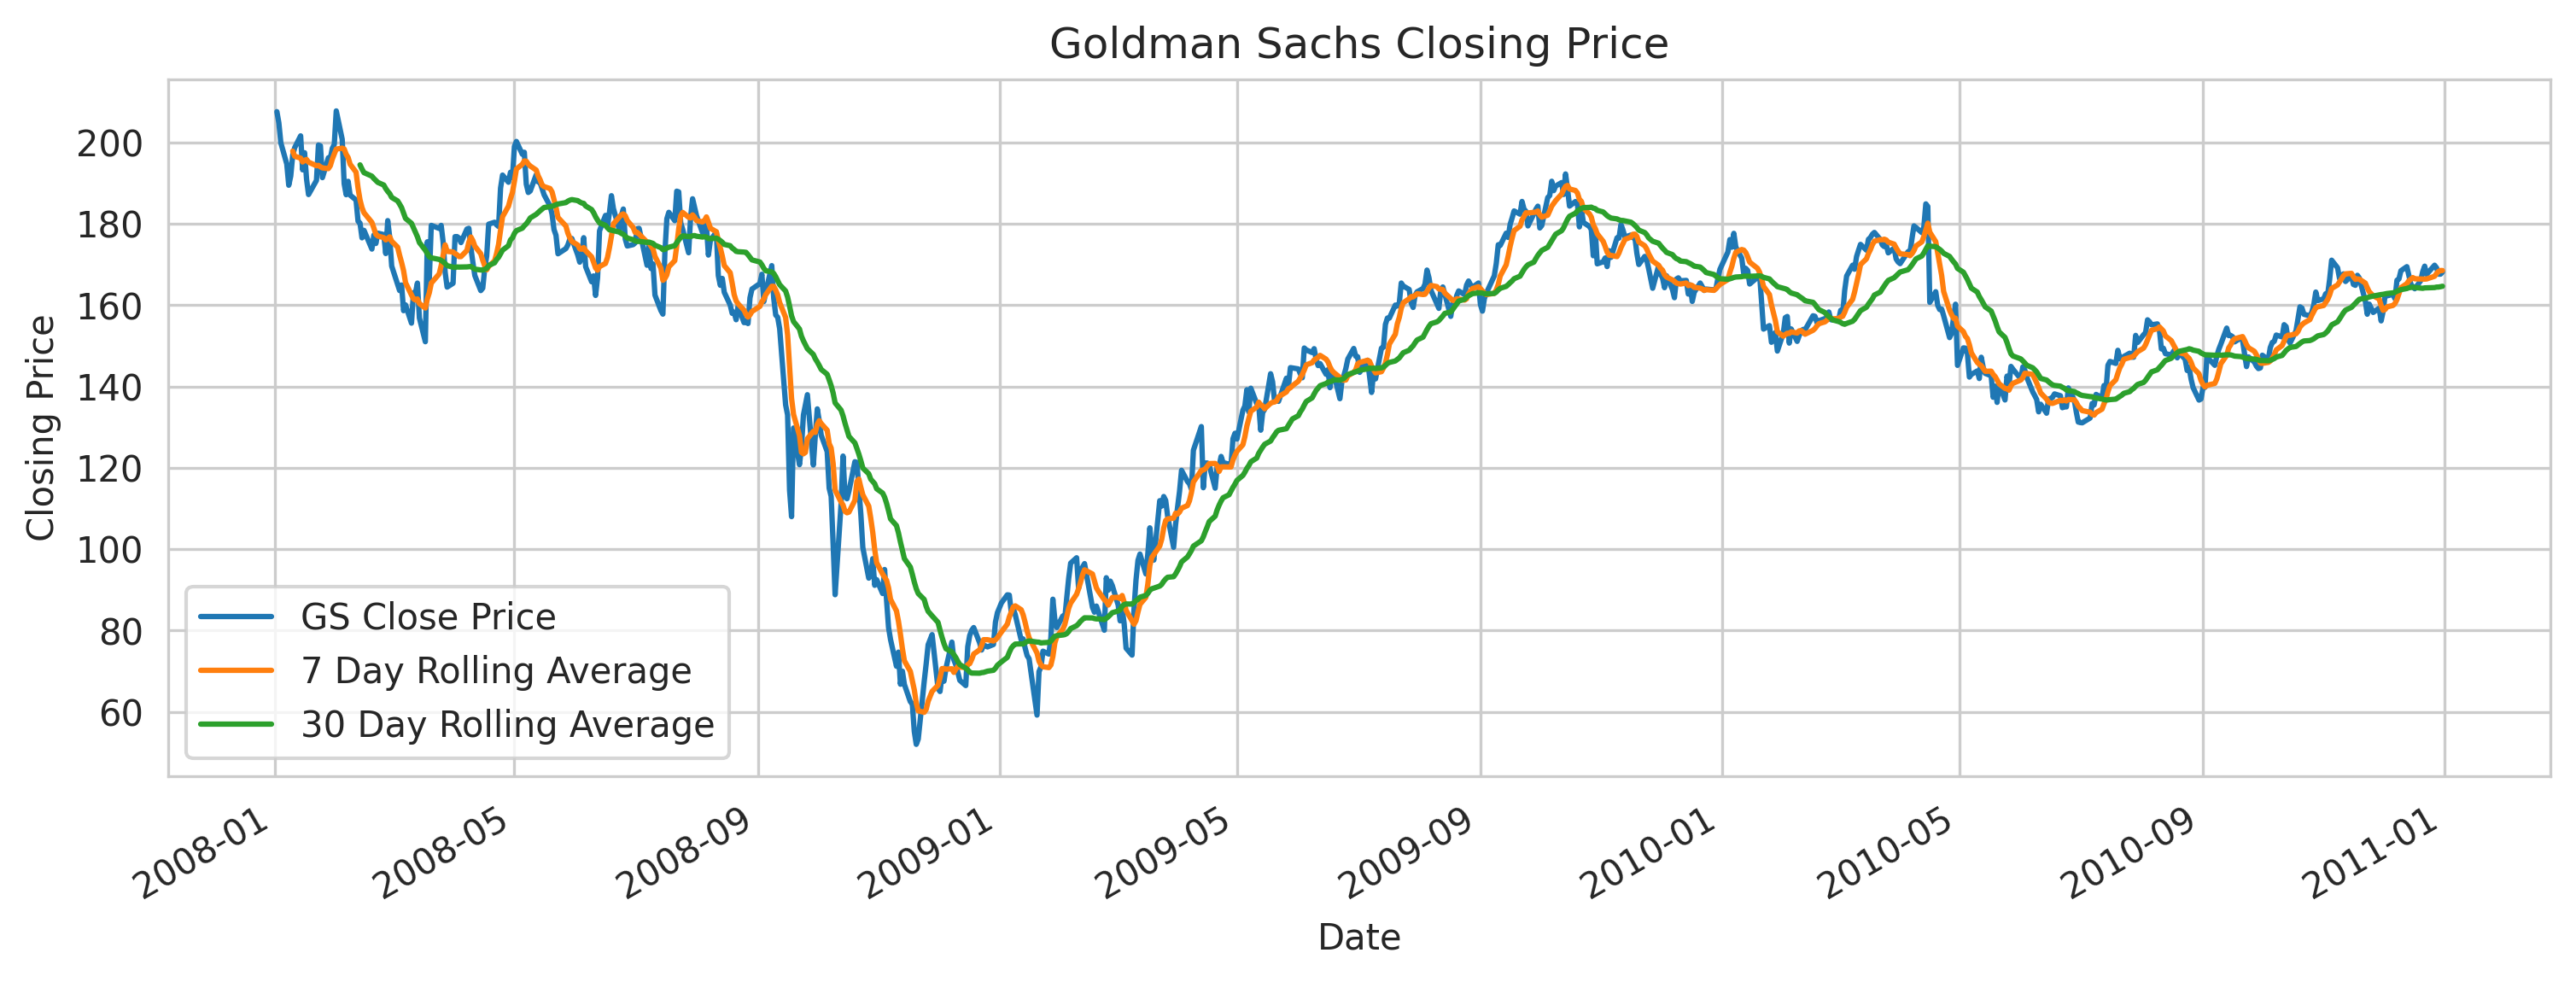

In [ ]:
# GS
plt.figure(figsize = (12, 4), dpi = 300)
bank_stocks["GS"]["Close"].loc["2008-01-01":"2011-01-01"].\
  plot(label = "GS Close Price")
bank_stocks["GS"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 7).mean().plot(label = "7 Day Rolling Average")
bank_stocks["GS"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 30).mean().plot(label = "30 Day Rolling Average")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Goldman Sachs Closing Price")
plt.show()


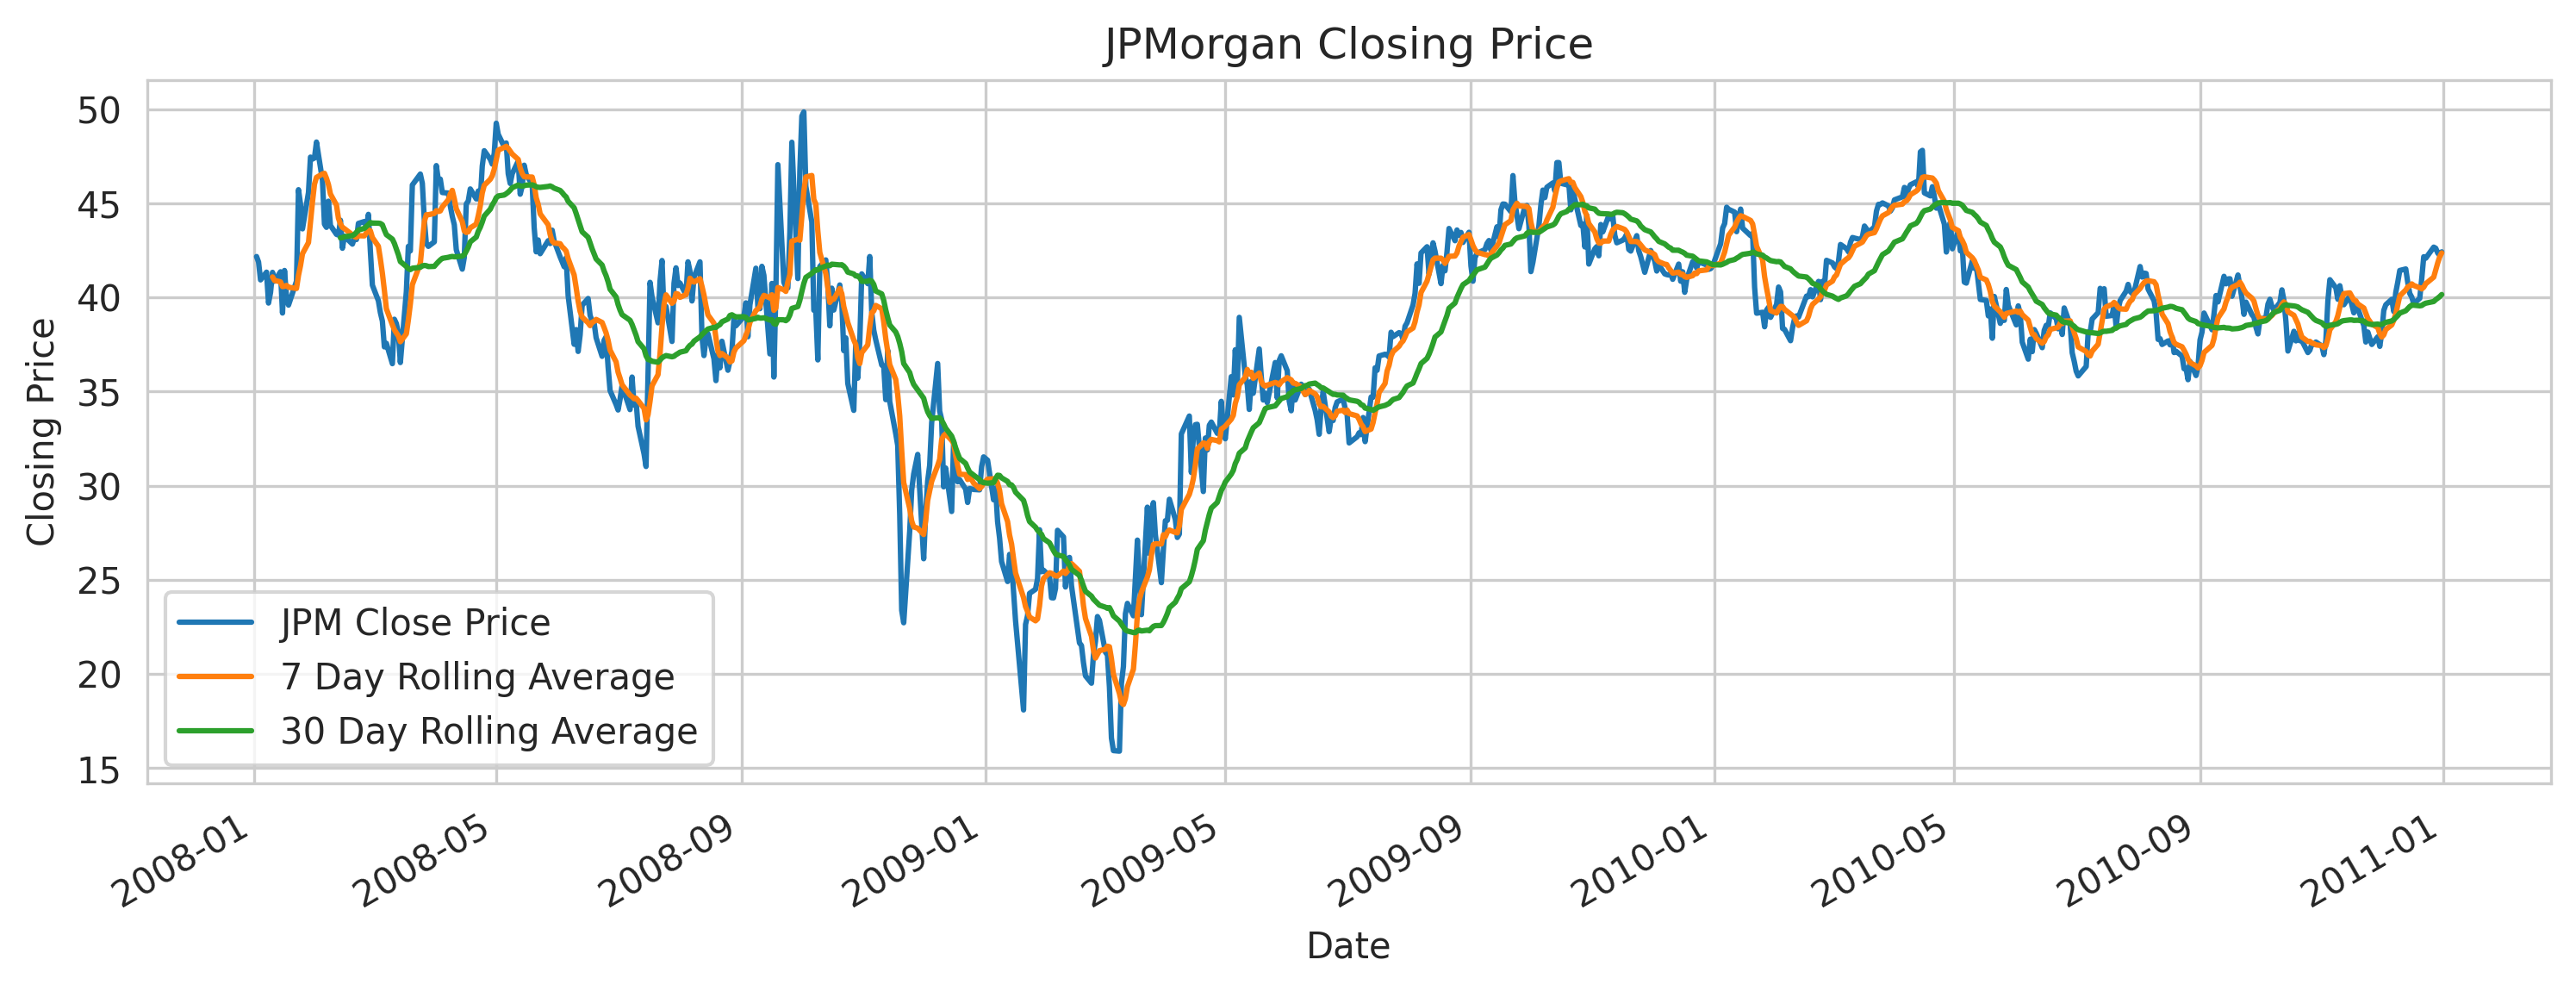

In [ ]:
# JPM
plt.figure(figsize = (12, 4), dpi = 300)
bank_stocks["JPM"]["Close"].loc["2008-01-01":"2011-01-01"].\
  plot(label = "JPM Close Price")
bank_stocks["JPM"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 7).mean().plot(label = "7 Day Rolling Average")
bank_stocks["JPM"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 30).mean().plot(label = "30 Day Rolling Average")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("JPMorgan Closing Price")
plt.show()

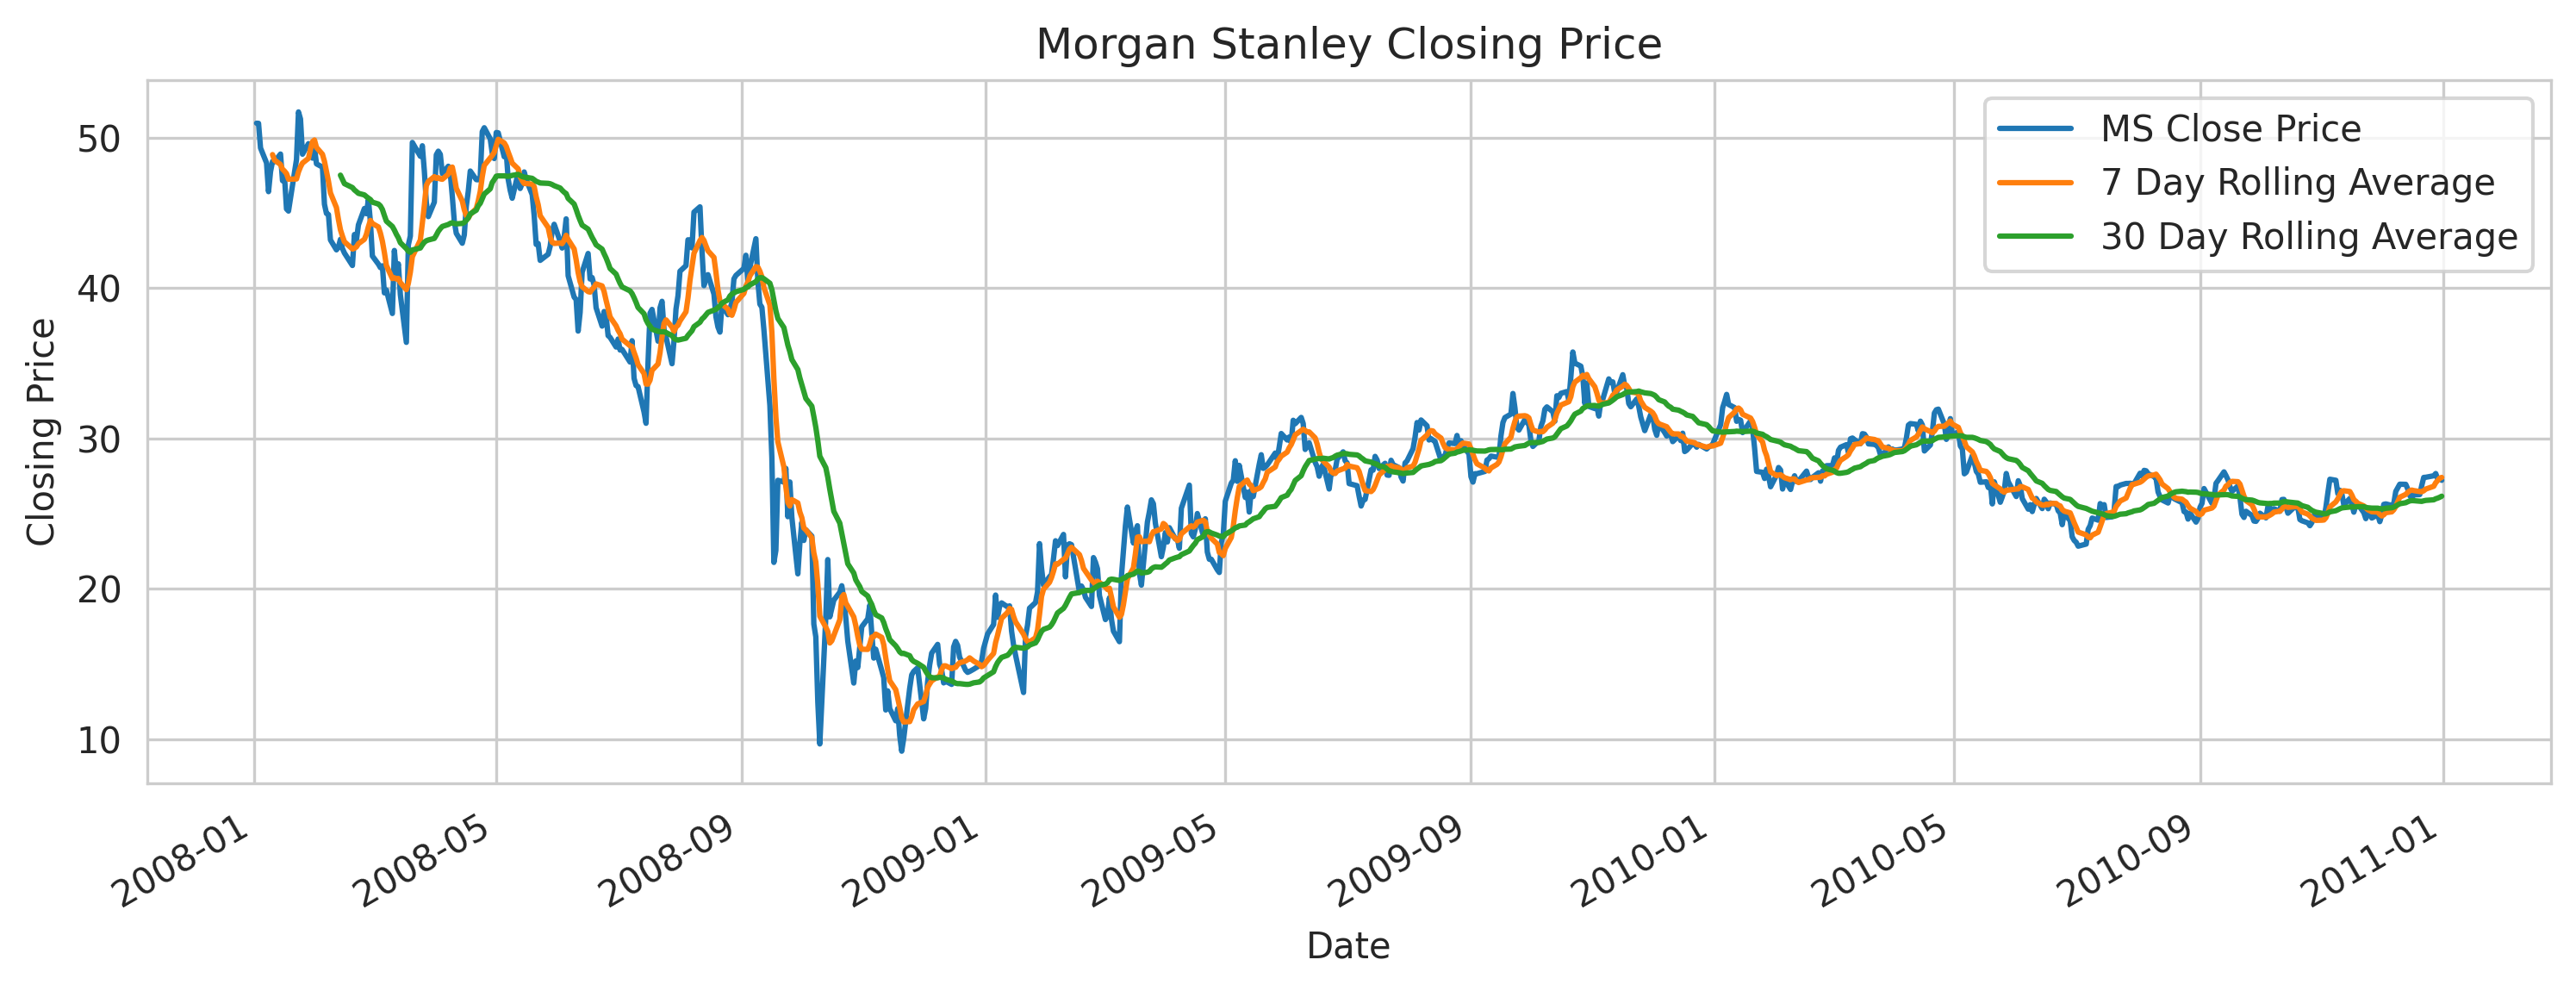

In [ ]:
# MS
plt.figure(figsize = (12, 4), dpi = 300)
bank_stocks["MS"]["Close"].loc["2008-01-01":"2011-01-01"].\
  plot(label = "MS Close Price")
bank_stocks["MS"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 7).mean().plot(label = "7 Day Rolling Average")
bank_stocks["MS"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 30).mean().plot(label = "30 Day Rolling Average")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Morgan Stanley Closing Price")
plt.show()

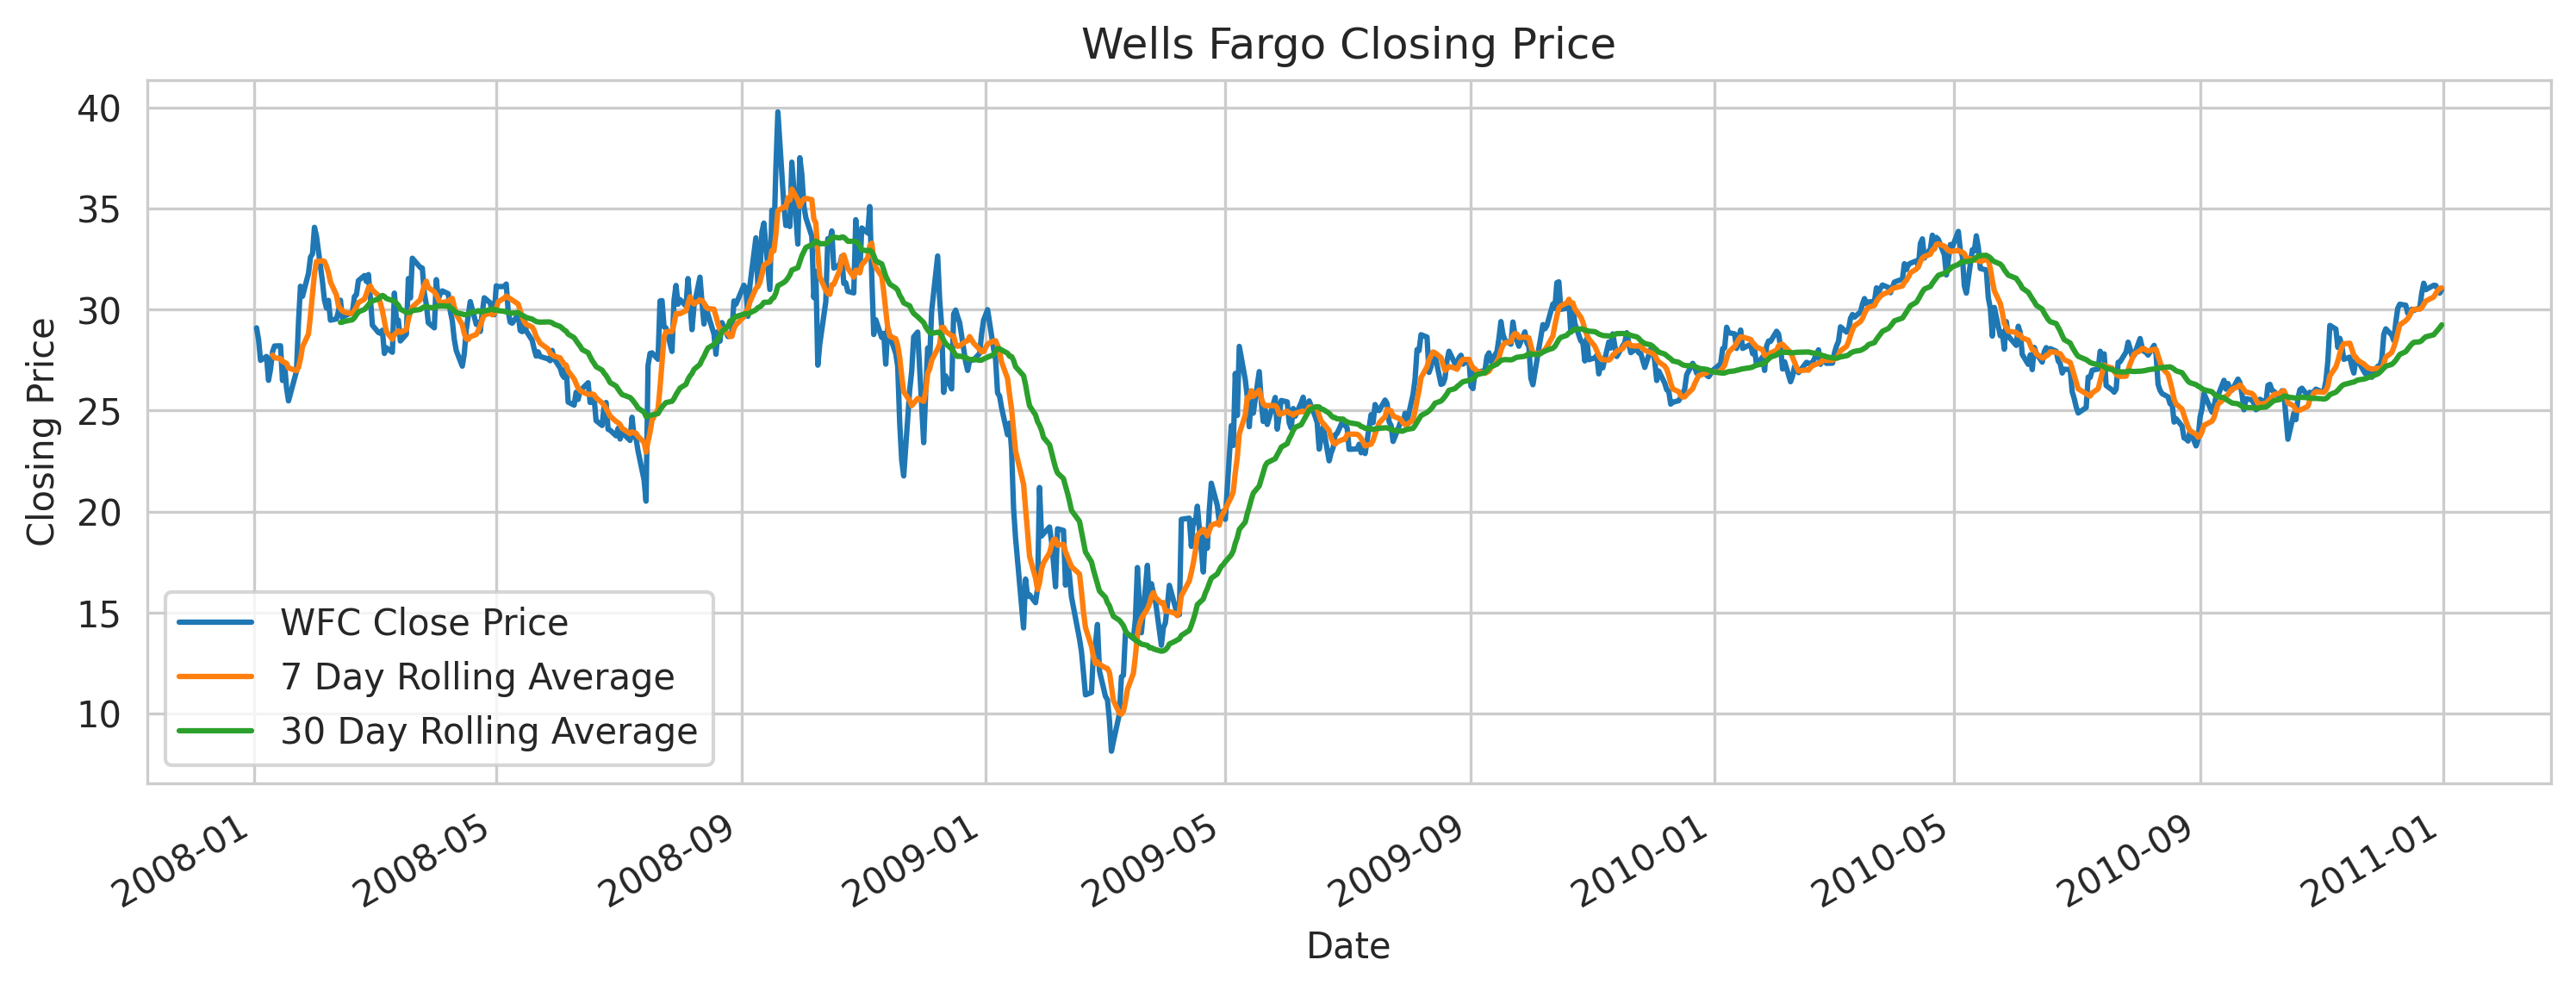

In [ ]:
# WFC
plt.figure(figsize = (12, 4), dpi = 300)
bank_stocks["WFC"]["Close"].loc["2008-01-01":"2011-01-01"].\
  plot(label = "WFC Close Price")
bank_stocks["WFC"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 7).mean().plot(label = "7 Day Rolling Average")
bank_stocks["WFC"]["Close"].loc["2008-01-01":"2011-01-01"].\
  rolling(window = 30).mean().plot(label = "30 Day Rolling Average")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Wells Fargo Closing Price")
plt.show()

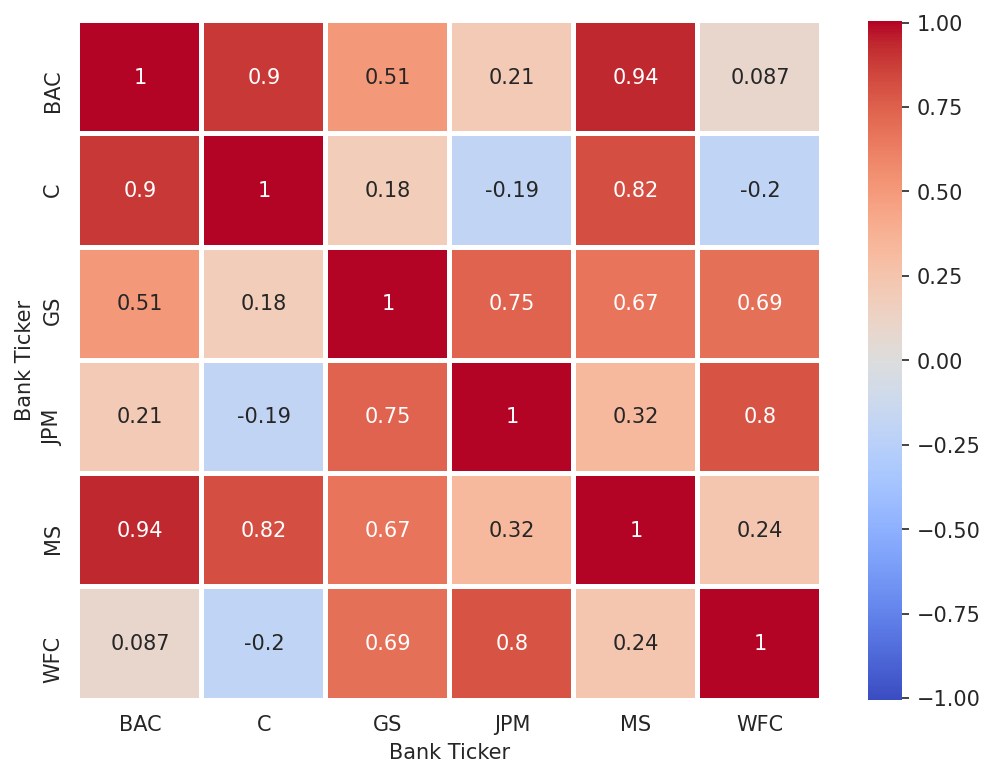

In [ ]:
# How are the stock prices correlated among each bank? (Look at closing price)
# Create a correlation matrix
corr_matrix = bank_stocks.xs(key = "Close", axis = 1, level = "Stock Info").\
              corr()

# Plot the matrix using a heatmap
plt.figure(figsize = (8, 6), dpi = 150)
# The vmin and vmax are set so the tickers aren't slightly off the bar 
# (looks nicer this way)
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", vmin = -1.006, 
            vmax = 1.006, linecolor = "white", linewidth = 2)
plt.show()

# Wow, some of the banks are very heavily correlated
# This means that when the closing price for one bank is higher than the 
# previous day, it is generally true that the correlated banks will also be up
# on the day
